# Analysis of predictions on yellow fever simulated reads (Sqlite)

???

# 1. Imports and setup environment

In [1]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [2]:
# Import all required packages
import json
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import re
import sqlite3
import time

from datetime import datetime
from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from functools import partial
from IPython.display import display, update_display, Markdown, HTML
from matplotlib.gridspec import GridSpec
from nbdev import show_doc
from pandas import HDFStore
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Any, Generator

# Setup the notebook for development
nb_setup()

from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader, TextFileBaseReader
from metagentools.cnn_virus.data import OriginalLabels
from metagentools.core import ProjectFileSystem

Set autoreload mode


List all computing devices available on the machine

# 2. Setup paths to files

Key folders and system information

In [3]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model

Path to the simulated read we want to use

In [4]:
fnames = files_in_tree(pfs.data / 'ncbi/simreads/yf', pattern='69seq')

simreads
  |--yf
  |    |--single_1seq_150bp
  |    |--single_69seq_150bp
  |    |    |--single_69seq_150bp.fq (0)
  |    |    |--single_69seq_150bp.aln (1)
  |    |--paired_1seq_150bp
  |    |--paired_69seq_150bp
  |    |    |--paired_69seq_150bp1.fq (2)
  |    |    |--paired_69seq_150bp2.fq (3)
  |    |    |--paired_69seq_150bp1.aln (4)
  |    |    |--paired_69seq_150bp2.aln (5)


In [5]:
file_stem = 'single_69seq_150bp'

p2aln = pfs.data / f"ncbi/simreads/yf/{file_stem[:-2] if file_stem[-1] in ['1', '2'] else file_stem}/{file_stem}.aln"
assert p2aln.exists()

p2db = Path('/mnt/k/metagentools/ncbi/infer_results/yf-ncbi') / f"{file_stem}.db"
assert p2db.exists()

In [6]:
aln = AlnFileReader(p2aln)

# Utility Functions

In [7]:
# Database functions
def open_db(p2db: Path,     # path to the sqlite database
            **kwargs
            ):
    """Open the sqlite database at p2db and return the connection object

    Create tables in case they do not exist, but for that `k` and `top_n` parameters must be passed
    """
    conn = sqlite3.connect(p2db)
    cursor = conn.cursor()
    query = "SELECT name FROM sqlite_master WHERE type='table' AND name='predictions'"
    res = cursor.execute(query).fetchone()
    if res is None or 'predictions' not in res:
        print('Tables do not exist yet. Creating tables in database...')
        k = kwargs.get('k', None)
        top_n = kwargs.get('top_n', None)
        if k is None or top_n is None:
            msg = 'both `k` and `top_n` must be explicitely provided to create the tables.'
            raise ValueError()
        create_tables(cursor, k=k, top_n=top_n)
    return conn

def table_columns(cursor:sqlite3.Cursor,  # cursor to the database  
                  table: str              # name of the table
                  ):
    """Returns the name of the columns in the passed table"""
    query = f"PRAGMA table_info({table})"
    cursor.execute(query)
    cols = [row[1] for row in cursor.fetchall()]
    return cols

def create_tables(cursor: sqlite3.Cursor,   # cursor to the database  
                  k:int=150,                # k-mer size
                  top_n: int=5              # number of top predictions to store, 5 by default   
                  ):
    """Create tables for the database"""
    # Create table for predictions
    pred_cols_str = 'readid refseqid refsource refseq_strand taxonomyid'.split(' ')
    pred_cols_int = 'lbl_true lbl_pred pos_true pos_pred'.split(' ')
    top_pred_cols = [f"top_{top_n}_lbl_pred_{i}" for i in range(top_n)]

    query = """
    CREATE TABLE IF NOT EXISTS predictions (
        id INTEGER PRIMARY KEY,
    """
    for col in pred_cols_str:
        query += f"{col} TEXT, "
    for col in pred_cols_int:
        query += f"{col} INTEGER, "
    for col in top_pred_cols:
        query += f"{col} INTEGER, "
    query = query[:-2]+')'
    # print(query)
    cursor.execute(query)

    query = "CREATE INDEX idx_preds ON predictions (readid, refseqid, pos_true);"
    cursor.execute(query)
    print('Table `predictions` created.')

    # Create table for probabilities (one per 50-mer in order to keep small nb or columns in table)

    query = f"""
    CREATE TABLE IF NOT EXISTS label_probabilities (
        id INTEGER PRIMARY KEY,
        read_kmer_id TEXT,
        read_50mer_nb INTEGER,
    """
    query += ','.join([f"prob_{i:03d}" for i in range(187)]) + " REAL, "
    query += "FOREIGN KEY (read_kmer_id) REFERENCES predictions(readid)"
    query += ')'
    cursor.execute(query)

    query = "CREATE INDEX idx_probs ON label_probabilities (read_kmer_id, read_50mer_nb);"
    cursor.execute(query)
    print(f'Table `label_probabilities` created.')

# SQL experiments

In [ ]:
with open_db(p2db=p2db, k=150) as conn:
    display(pd.read_sql_query("SELECT * FROM predictions WHERE readid = '11089:ncbi:1-17000';", conn))
    display(pd.read_sql_query("SELECT * FROM label_probabilities WHERE read_kmer_id = '11089:ncbi:1-17000';", conn))

In [ ]:
with open_db(p2db=p2db, k=150) as conn:
    last_readid = conn.execute("SELECT MAX(id) FROM predictions").fetchone()[0]
    readid = conn.execute(f"SELECT readid FROM predictions WHERE id = {last_readid};").fetchone()[0]
    regex = re.compile(r'\d*:ncbi:(?P<read_nb>\d*-\d*)')
    m = regex.search(readid)
    read_nb = '???' if m is None else m.group('read_nb')

last_readid, readid, read_nb

# Analysis

Metrics: in effect, we have a binary classification problem here because all the simread are from yellow fever. This means prediction are either TP or FN. Consequently, accuracy = recall and we cannot evaluate precision.

## Accuracy per reference sequence

In [8]:
print('\n'.join(aln.header['reference sequences']))

@SQ	11089:ncbi:1	1	AY968064	11089	ncbi	Angola_1971	10237
@SQ	11089:ncbi:2	2	U54798	11089	ncbi	Ivory_Coast_1982	10237
@SQ	11089:ncbi:3	3	DQ235229	11089	ncbi	Ethiopia_1961	10237
@SQ	11089:ncbi:4	4	AY572535	11089	ncbi	Gambia_2001	10237
@SQ	11089:ncbi:5	5	MF405338	11089	ncbi	Ghana_Hsapiens_1927	10237
@SQ	11089:ncbi:6	6	U21056	11089	ncbi	Senegal_1927	10237
@SQ	11089:ncbi:7	7	AY968065	11089	ncbi	Uganda_1948	10237
@SQ	11089:ncbi:8	8	JX898871	11089	ncbi	ArD114896_Senegal_1995	10237
@SQ	11089:ncbi:9	9	JX898872	11089	ncbi	Senegal_Aedes-aegypti_1995	10237
@SQ	11089:ncbi:10	10	GQ379163	11089	ncbi	Peru_Hsapiens_2007	10237
@SQ	11089:ncbi:11	11	DQ118157	11089	ncbi	Spain_Vaccine_2004	10237
@SQ	11089:ncbi:12	12	MF289572	11089	ncbi	Singapore_2017	10237
@SQ	11089:ncbi:13	13	KU978764	11089	ncbi	Sudan_Hsapiens_1941	10237
@SQ	11089:ncbi:14	14	JX898878	11089	ncbi	ArD181250_Senegal_2005	10237
@SQ	11089:ncbi:15	15	JX898879	11089	ncbi	ArD181676_Senegal_2005	10237
@SQ	11089:ncbi:16	16	JX898881	11089	ncbi	Senegal

In [9]:
refseq_metadata = aln.parse_header_reference_sequences()
refseq_metadata['11089:ncbi:1']

{'organism': 'Angola_1971',
 'refseq_accession': 'AY968064',
 'refseq_length': '10237',
 'refseqid': '11089:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '11089'}

In [10]:
def refseqid2organism(refseqid:str):
    return refseq_metadata[refseqid]['organism']

refseqid2organism('11089:ncbi:1')

'Angola_1971'

### Compute accuracy stats from DB and save per refseq report on disk

In [11]:
with open_db(p2db=p2db, k=150) as conn:
    cursor = conn.cursor()
    print(table_columns(cursor, 'predictions'))

['id', 'readid', 'refseqid', 'refsource', 'refseq_strand', 'taxonomyid', 'lbl_true', 'lbl_pred', 'pos_true', 'pos_pred', 'top_5_lbl_pred_0', 'top_5_lbl_pred_1', 'top_5_lbl_pred_2', 'top_5_lbl_pred_3', 'top_5_lbl_pred_4']


In [ ]:
BUILD_ACCURACY_DATASET = False

if BUILD_ACCURACY_DATASET:

    n_position_bins = 50
    cols = 'refseqid organism refseq_length nb_simreads mean_acc std_acc'.split(' ')
    cols_acc_per_pos = [f"acc_pos_{i:02d}" for i in range(1, n_position_bins+1)]
    cols = cols + cols_acc_per_pos

    stats_per_refseq = pd.DataFrame(columns=cols)

    for i, (refseqid, metadata) in enumerate(refseq_metadata.items()):
        # Retrieve metadata for this reference sequence
        organism = metadata['organism']
        refseq_length = metadata['refseq_length']
        print(f"{i:2d}. {organism} ({refseqid})")

        # Retrieve predictions for all simulated reads aligned to this reference sequence
        with open_db(p2db=p2db, k=150) as conn:
            query = "SELECT readid, refseqid, lbl_true, lbl_pred, pos_true, pos_pred FROM predictions "
            query += f"WHERE refseqid = '{refseqid}'; "
            df = pd.read_sql_query(query, conn)

        # Compute statistics
        nb_simreads = df.shape[0]
        df['accuracy'] = df.lbl_true == df.lbl_pred
        refseq_acc_mean = df['accuracy'].mean()
        refseq_acc_std = df['accuracy'].std()

        bins = [0 + n * 10237/n_position_bins for n in range(n_position_bins+1)]
        df['pos_bin'] = pd.cut(df['pos_true'], bins, retbins=False)
        df['pos_bin'].cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins
        per_pos = df.groupby('pos_bin')
        per_pos_acc_mean = per_pos.accuracy.mean()
        
        row = pd.DataFrame(
            index=['refseqid'],
            columns=cols,
            data = [[refseqid, organism, refseq_length, nb_simreads, refseq_acc_mean, refseq_acc_std] + per_pos_acc_mean.tolist()]
        )
        
        stats_per_refseq = pd.concat(
            [
                stats_per_refseq,
                row
            ],
            axis=0,
            ignore_index=True)


    display(stats_per_refseq.shape)

In [ ]:
p2stats_per_refseq = pfs.data / 'ncbi/infer_results/yf-ncbi/analysis' / f"{file_stem}/{file_stem}_stats_per_refseq.csv"
# stats_per_refseq.to_csv(p2stats_per_refseq, index=False)

### Load accuracy per refseq report and plot

In [ ]:
stats_per_refseq = pd.read_csv(p2stats_per_refseq, index_col='refseqid')

Plot accuracy per reference sequence and per position

In [ ]:
def plot_accuracy_per_refseq(df: pd.DataFrame, figsize=(15,10), ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    sorted_df = df.sort_values(by='mean_acc', ascending=True)
    sorted_df.mean_acc.plot(ax=ax, kind='barh', width=.6, title="Mean accuracy per reference sequence")
    ax.set_xlabel('Mean Accuracy')
    ax.set_yticklabels(sorted_df.organism)
    ax.set_ylabel('Reference Sequence')
    for v in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.vlines(x=v, ymin=-1, ymax=sorted_df.shape[0], colors='gray', linestyles='solid', alpha=0.5)
    if ax is None: plt.show()

# plot_accuracy_per_refseq(stats_per_refseq.loc[stats_per_refseq.mean_acc.notna(), :], figsize=(10,20))

In [ ]:
def plot_accuracy_per_position(df: pd.DataFrame, refseqid: str, n_position_bins: int=50, figsize=(15,3), ax=None, dense=False):
    accuracy = df.loc[refseqid, 'mean_acc']
    organism = df.loc[refseqid, 'organism']
    acc_per_position = df.loc[refseqid, cols_acc_per_pos].T
    acc_per_position.index = range(1, n_position_bins+1)

    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    bar_w = 1 if dense else 0.6
    acc_per_position.plot(ax=ax, kind='bar', ylim=(0,1), width=bar_w, legend=False)
    ax.set_title(f"{organism}: accuracy per simread relative position (mean accuracy:{accuracy:.3f})")
    if dense:
        ax.hlines(y=0.5, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid', alpha=0.5)
    else:
        ax.hlines(y=0.6, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.7, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.8, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.9, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
    ax.set_xlabel('relative position in reference sequence')
    ax.set_ylabel('accuracy')
    if ax is None: plt.show()

# plot_accuracy_per_position(stats_per_refseq, '11089:ncbi:23')


In [ ]:
def plot_accuracy(df: pd.DataFrame, figsize=(15,25)):
    
    # Create a figure and GridSpec object
    fig = plt.figure(figsize=(15, 25))
    fig.suptitle('Accuracy per Reference Sequence and Genome Alignment Positions', fontsize=18)
    nb_refseq = df.shape[0]
    gs = GridSpec(nb_refseq, 3, figure=fig)

    # Create left axes 
    ax_left = fig.add_subplot(gs[0:, 0])
    ax_left.set_title('Acc per refseq')
    plot_accuracy_per_refseq(df, ax=ax_left)
    ax_left.set_title(None)
    ax_left_position = ax_left.get_position()
    left_y1 = ax_left_position.y1
    left_h = ax_left_position.height
    hbar_plot_h = left_h / nb_refseq
    hbar_h = hbar_plot_h * 0.6
    hbar_padding_top = hbar_plot_h * 0.2 

    # Create other subplots
    axs = []
    for i, (refseqid, _) in enumerate(df.sort_values(by='mean_acc', ascending=False).iterrows()):
        ax = fig.add_subplot(gs[i, 1:])
        plot_accuracy_per_position(df, refseqid, ax=ax, dense=True)
        # ovwerwrite axes properties
        if i == nb_refseq-1: 
            ax.set_xlabel('alignment position of read')
        else:
            ax.set_xlabel(None)
            ax.set_xticks([])
            ax.set_xticklabels([])
        ax.set_ylabel(None)
        ax.set_yticks([0, 1])
        ax.set_yticklabels([0,1])
        ax.set_title(None)
            
        ax_pos = ax.get_position()
        ax_y0 = left_y1 - hbar_padding_top - hbar_h - i * hbar_plot_h
        ax.set_position([ax_pos.x0 , ax_y0, ax_pos.width, hbar_h])
        left_title_x = ax_left_position.x0 + ax_left_position.width/2
        right_title_x = ax_pos.x0 + ax_pos.width/2   
        title_y = ax_left_position.y1 - (1-ax_left_position.y1)*.33
        plt.annotate('Accuracy per Reference Sequence', xy=(left_title_x,title_y ), ha='center', xycoords='figure fraction', fontsize=16, color='white')
        plt.annotate('Accuracy per Position', xy=(right_title_x,title_y ), ha='left', xycoords='figure fraction', fontsize=16, color='white')
        axs.append(ax)

    plt.show()

In [ ]:
stats = stats_per_refseq.loc[stats_per_refseq.mean_acc.notna(), :] #.iloc[:10,:]
plot_accuracy(stats)

## Probability Analysis

In [12]:
aln.reset_iterator()
refseq_meta = aln.parse_header_reference_sequences()
print(refseq_meta[list(refseq_meta.keys())[0]])
print(refseq_meta['11089:ncbi:8']['organism'])
print(refseq_meta['11089:ncbi:8']['refseq_length'])

{'organism': 'Angola_1971', 'refseq_accession': 'AY968064', 'refseq_length': '10237', 'refseqid': '11089:ncbi:1', 'refseqnb': '1', 'refsource': 'ncbi', 'reftaxonomyid': '11089'}
ArD114896_Senegal_1995
10237


In [13]:
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    print(table_columns(cursor, 'predictions'))
    print(table_columns(cursor, 'label_probabilities'))

['id', 'readid', 'refseqid', 'refsource', 'refseq_strand', 'taxonomyid', 'lbl_true', 'lbl_pred', 'pos_true', 'pos_pred', 'top_5_lbl_pred_0', 'top_5_lbl_pred_1', 'top_5_lbl_pred_2', 'top_5_lbl_pred_3', 'top_5_lbl_pred_4']
['id', 'read_kmer_id', 'read_50mer_nb', 'prob_000', 'prob_001', 'prob_002', 'prob_003', 'prob_004', 'prob_005', 'prob_006', 'prob_007', 'prob_008', 'prob_009', 'prob_010', 'prob_011', 'prob_012', 'prob_013', 'prob_014', 'prob_015', 'prob_016', 'prob_017', 'prob_018', 'prob_019', 'prob_020', 'prob_021', 'prob_022', 'prob_023', 'prob_024', 'prob_025', 'prob_026', 'prob_027', 'prob_028', 'prob_029', 'prob_030', 'prob_031', 'prob_032', 'prob_033', 'prob_034', 'prob_035', 'prob_036', 'prob_037', 'prob_038', 'prob_039', 'prob_040', 'prob_041', 'prob_042', 'prob_043', 'prob_044', 'prob_045', 'prob_046', 'prob_047', 'prob_048', 'prob_049', 'prob_050', 'prob_051', 'prob_052', 'prob_053', 'prob_054', 'prob_055', 'prob_056', 'prob_057', 'prob_058', 'prob_059', 'prob_060', 'prob_0

Retrieve all the simreads for a specific refseqid

In [10]:
%%time
# CPU times: user 417 ms, sys: 339 ms, total: 756 ms
# Wall time: 43.4 s
refseqid = '11089:ncbi:8'

with open_db(p2db=p2db) as conn:
    query = "SELECT readid, refseqid, lbl_true, lbl_pred, pos_true, pos_pred FROM predictions "
    query += f"WHERE refseqid = '{refseqid}'; "
    df = pd.read_sql_query(query, conn)

df.shape

CPU times: user 417 ms, sys: 339 ms, total: 756 ms
Wall time: 43.4 s


(17000, 6)

In [12]:
display(df.head())

,readid,refseqid,lbl_true,lbl_pred,pos_true,pos_pred
0,11089:ncbi:8-17000,11089:ncbi:8,118,118,2820,6
1,11089:ncbi:8-16999,11089:ncbi:8,118,118,6944,6
2,11089:ncbi:8-16998,11089:ncbi:8,118,118,6895,3
3,11089:ncbi:8-16997,11089:ncbi:8,118,118,3329,3
4,11089:ncbi:8-16996,11089:ncbi:8,118,118,1648,7


Retrieve all 50-mer probabilities for all these reads

In [13]:
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    print(table_columns(cursor, 'predictions'))
    print(table_columns(cursor, 'label_probabilities'))

['id', 'readid', 'refseqid', 'refsource', 'refseq_strand', 'taxonomyid', 'lbl_true', 'lbl_pred', 'pos_true', 'pos_pred', 'top_5_lbl_pred_0', 'top_5_lbl_pred_1', 'top_5_lbl_pred_2', 'top_5_lbl_pred_3', 'top_5_lbl_pred_4']
['id', 'read_kmer_id', 'read_50mer_nb', 'prob_000', 'prob_001', 'prob_002', 'prob_003', 'prob_004', 'prob_005', 'prob_006', 'prob_007', 'prob_008', 'prob_009', 'prob_010', 'prob_011', 'prob_012', 'prob_013', 'prob_014', 'prob_015', 'prob_016', 'prob_017', 'prob_018', 'prob_019', 'prob_020', 'prob_021', 'prob_022', 'prob_023', 'prob_024', 'prob_025', 'prob_026', 'prob_027', 'prob_028', 'prob_029', 'prob_030', 'prob_031', 'prob_032', 'prob_033', 'prob_034', 'prob_035', 'prob_036', 'prob_037', 'prob_038', 'prob_039', 'prob_040', 'prob_041', 'prob_042', 'prob_043', 'prob_044', 'prob_045', 'prob_046', 'prob_047', 'prob_048', 'prob_049', 'prob_050', 'prob_051', 'prob_052', 'prob_053', 'prob_054', 'prob_055', 'prob_056', 'prob_057', 'prob_058', 'prob_059', 'prob_060', 'prob_0

### Experimenting response time of sqlite database

In [15]:
%%time
# Retrieve three columns filtering on id
# CPU times: user 86.4 ms, sys: 27.7 ms, total: 114 ms
# Wall time: 3.03 s
with open_db(p2db=p2db) as conn:
    query = f"""
    SELECT id, read_kmer_id, read_50mer_nb
    FROM label_probabilities 
    WHERE id IN ({','.join([str(x) for x in range(20_000)])})
    LIMIT 1000 ;
    """
    # print(query)
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail(5))

(1000, 3)


,id,read_kmer_id,read_50mer_nb
995,996,11089:ncbi:1-16517,1
996,997,11089:ncbi:1-16516,1
997,998,11089:ncbi:1-16515,1
998,999,11089:ncbi:1-16514,1
999,1000,11089:ncbi:1-16513,1


CPU times: user 86.4 ms, sys: 27.7 ms, total: 114 ms
Wall time: 3.03 s


In [16]:
%%time
# Retrieve all colomns filtering on id
# CPU times: user 146 ms, sys: 33.2 ms, total: 179 ms
# Wall time: 3.69 s
with open_db(p2db=p2db) as conn:
    query = f"""
    SELECT *
    FROM label_probabilities 
    WHERE id IN ({','.join([str(x) for x in range(20000)])})
    LIMIT 1000 ;
    """
    # print(query)
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail(5))

(1000, 190)


,id,read_kmer_id,read_50mer_nb,prob_000,prob_001,prob_002,prob_003,prob_004,prob_005,prob_006,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
995,996,11089:ncbi:1-16517,1,8.754474e-05,1.7678653e-21,3.634549e-05,0.0038874687,9.118338e-09,9.198738e-05,0.25078282,...,0.0004519505,2.1182933e-09,4.094599e-12,2.3100396e-18,1.3200581e-17,8.3177587e-10,9.040084e-16,1.1082036e-19,9.195436e-15,1.281601e-05
996,997,11089:ncbi:1-16516,1,7.5915164e-13,4.9807175e-17,5.303934e-15,3.7269323e-15,1.045666e-08,1.1862427e-15,2.4500586e-11,...,2.5184195e-14,2.095439e-18,9.399496e-17,3.814011e-19,6.360825e-15,1.5203839e-13,5.7828874e-19,1.778119e-17,3.0860775e-19,2.622951e-18
997,998,11089:ncbi:1-16515,1,2.7855967e-06,1.00908907e-19,1.289632e-13,1.2527812e-08,2.140582e-07,5.2963238e-11,3.072991e-08,...,4.875204e-10,1.1337102e-11,1.684754e-11,5.9170376e-18,3.030622e-19,4.96021e-18,1.8964816e-16,3.3222575e-20,1.0954248e-15,3.198112e-16
998,999,11089:ncbi:1-16514,1,1.2838345e-12,1.223785e-15,2.734925e-11,1.731637e-22,0.94311,2.3930939e-16,4.2285706e-12,...,2.3002339e-10,9.64501e-21,1.0266413e-16,3.043349e-24,4.858454e-17,9.689134e-17,5.8541106e-18,6.4746914e-27,2.3560985e-25,1.425361e-24
999,1000,11089:ncbi:1-16513,1,1.9092526e-05,4.6979976e-13,2.834131e-12,1.0610391e-06,0.117659755,1.1744167e-11,1.1163678e-14,...,8.021518e-15,7.36918e-18,6.466401e-16,3.1235835e-17,4.1697658e-18,9.649253e-16,3.6909373e-08,2.5215108e-13,8.0728805e-21,3.898578e-15


CPU times: user 146 ms, sys: 33.2 ms, total: 179 ms
Wall time: 3.69 s


In [17]:
%%time
# Retrieve 4 columns filtering on read_kmer_id
# CPU times: user 25.1 ms, sys: 15.3 ms, total: 40.4 ms
# Wall time: 1.61 s
with open_db(p2db=p2db) as conn:
    # id, read_kmer_id, read_50mer_nb, prob_001
    query = f"""
    SELECT id, read_kmer_id, read_50mer_nb, prob_001
    FROM label_probabilities 
    WHERE read_kmer_id = '11089:ncbi:1-1'
    LIMIT 1000 ;
    """
    # print(query)
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(101, 4)


,id,read_kmer_id,read_50mer_nb,prob_001
96,1755752,11089:ncbi:1-1,96,9.605288e-18
97,1756264,11089:ncbi:1-1,97,1.05488615e-20
98,1756776,11089:ncbi:1-1,98,1.7379728e-17
99,1757288,11089:ncbi:1-1,99,8.715563e-21
100,1757800,11089:ncbi:1-1,100,7.744164e-18


CPU times: user 25.1 ms, sys: 15.3 ms, total: 40.4 ms
Wall time: 1.61 s


In [19]:
%%time
# Retrieve 4 columns filtering on read_kmer_id and using a list
# CPU times: user 54.8 ms, sys: 10.1 ms, total: 64.9 ms
# Wall time: 1.82 s
with open_db(p2db=p2db) as conn:
    # id, read_kmer_id, read_50mer_nb, prob_001
    query = f"""
    SELECT id, read_kmer_id, read_50mer_nb, prob_001
    FROM label_probabilities 
    WHERE read_kmer_id IN ('11089:ncbi:1-1', '11089:ncbi:1-2', '11089:ncbi:1-3', '11089:ncbi:1-4')
    LIMIT 1000 ;
    """
    # print(query)
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(404, 4)


,id,read_kmer_id,read_50mer_nb,prob_001
399,1755749,11089:ncbi:1-4,96,4.901561e-16
400,1756261,11089:ncbi:1-4,97,6.86821e-16
401,1756773,11089:ncbi:1-4,98,2.2368514e-14
402,1757285,11089:ncbi:1-4,99,3.8160105e-15
403,1757797,11089:ncbi:1-4,100,7.088436e-17


CPU times: user 54.8 ms, sys: 10.1 ms, total: 64.9 ms
Wall time: 1.82 s


List all indexes in the database

In [20]:
def list_indexes(p2db):
    """List all indexes in the database and their columns"""
    with open_db(p2db=p2db) as conn:
        cursor = conn.cursor()
        query = f"""
        SELECT name, tbl_name FROM sqlite_master WHERE type='index' ;
        """
        cursor.execute(query)
        indexes = cursor.fetchall()
        for index in indexes:
            print(f"{index[0]} for table '{index[1]}':")
            cursor.execute(f"PRAGMA index_info({index[0]}) ;")
            for col_info in cursor.fetchall():
                print(f" - {col_info[2]}")

list_indexes(p2db)

idx_preds for table 'predictions':
 - readid
 - refseqid
 - pos_true
idx_probs for table 'label_probabilities':
 - read_kmer_id
 - read_50mer_nb


Creating a view to combine `predictions` and `label_probabilities`

In [21]:
def list_views(p2db):
    with open_db(p2db) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='view';")
        views = cursor.fetchall()
        for view in views:
            print(view[0])
            print('  ',', '.join(table_columns(cursor, view[0])))

        # cursor.execute("DROP VIEW IF EXISTS preds_probs;")
        # conn.commit()

        # cursor.execute("SELECT name FROM sqlite_master WHERE type='view';")
        # views = cursor.fetchall()
        # for view in views:
        #     print(view[0])
list_views(p2db)

preds_probs
   refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_0, top_5_lbl_pred_1, top_5_lbl_pred_2, top_5_lbl_pred_3, top_5_lbl_pred_4, top_5_lbl_pred_0:1, top_5_lbl_pred_1:1, top_5_lbl_pred_2:1, top_5_lbl_pred_3:1, top_5_lbl_pred_4:1, top_5_lbl_pred_0:2, top_5_lbl_pred_1:2, top_5_lbl_pred_2:2, top_5_lbl_pred_3:2, top_5_lbl_pred_4:2, top_5_lbl_pred_0:3, top_5_lbl_pred_1:3, top_5_lbl_pred_2:3, top_5_lbl_pred_3:3, top_5_lbl_pred_4:3, top_5_lbl_pred_0:4, top_5_lbl_pred_1:4, top_5_lbl_pred_2:4, top_5_lbl_pred_3:4, top_5_lbl_pred_4:4, read_kmer_id, read_50mer_nb, prob_000, prob_001, prob_002, prob_003, prob_004, prob_005, prob_006, prob_007, prob_008, prob_009, prob_010, prob_011, prob_012, prob_013, prob_014, prob_015, prob_016, prob_017, prob_018, prob_019, prob_020, prob_021, prob_022, prob_023, prob_024, prob_025, prob_026, prob_027, prob_028, prob_029, prob_030, prob_031, prob_032, prob_033, prob_034, prob_035, prob_036, prob_037, prob_038, prob_039, prob_040, prob_0

In [22]:
# Create a view
# with open_db(p2db=p2db) as conn:
#     # 'readid', 'refseqid', 'refsource', 'refseq_strand', 'taxonomyid', 'lbl_true', 'lbl_pred', 'pos_true', 'pos_pred', 'top_5_lbl_pred_0', 'top_5_lbl_pred_1', 'top_5_lbl_pred_2', 'top_5_lbl_pred_3', 'top_5_lbl_pred_4'
#     cursor = conn.cursor()
#     top_lbl_pred_n = ','.join([f"p.top_5_lbl_pred_{j}" for i in range(5) for j in range(5)])
#     probs_n = ','.join([f"lp.prob_{i:03d}" for i in range(187)])
#     query = f"""
#         CREATE VIEW preds_probs AS
#         SELECT 
#             p.refseqid,
#             p.lbl_true, p.lbl_pred,
#             p.pos_true, p.pos_pred,
#             {top_lbl_pred_n},
#             lp.read_kmer_id, lp.read_50mer_nb,
#             {probs_n}
#         FROM 
#             label_probabilities lp
#         INNER JOIN 
#             predictions p
#         ON 
#             lp.read_kmer_id = p.readid
#     """
#     # print(query)
#     cursor.execute(query)

### Fastest way so far to retrieve the data

1. create a view joining prediction and label_probabilities tables: `preds_probs`
2. query `preds_probs` view to retrieve all probabilities for a specific refseqid

This gives a wall time of 26 sec, and only 346 ms of CPU time for 2500 rows.
We do have a IO access problem as it takes 25 sec to read 2500 rows from the database.

In [23]:
%%time
# Retrieve specific columns and filtering on refseqid
# CPU times: user 72.2 ms, sys: 20.5 ms, total: 92.8 ms
# Wall time: 5.65 s
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    # refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_n, read_kmer_id, read_50mer_nb, prob_001, prob_002, 
    query = f"""
    SELECT refseqid, pos_true, read_kmer_id, read_50mer_nb, prob_001
    FROM preds_probs 
    WHERE refseqid = '11089:ncbi:1'
    LIMIT 1000 ;
    """
    # print(query)
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(1000, 5)


,refseqid,pos_true,read_kmer_id,read_50mer_nb,prob_001
995,11089:ncbi:1,9190,11089:ncbi:1-10005,86,3.296778e-07
996,11089:ncbi:1,9190,11089:ncbi:1-10005,87,6.6583444e-14
997,11089:ncbi:1,9190,11089:ncbi:1-10005,88,2.073386e-09
998,11089:ncbi:1,9190,11089:ncbi:1-10005,89,2.152935e-12
999,11089:ncbi:1,9190,11089:ncbi:1-10005,90,8.5074834e-07


CPU times: user 72.2 ms, sys: 20.5 ms, total: 92.8 ms
Wall time: 5.65 s


Wall time of 6 sec for 1,000 rows.

Each refseqid has 17,000 readid, each readid has 101 read_50_mers: 1,717,000 rows in total.

Time to retrieve 1,717,000 rows should be 2 min 30 sec

In [24]:
%%time
# Retrieve all columns and filtering on refseqid
# CPU times: user 171 ms, sys: 80.5 ms, total: 251 ms
# Wall time: 6.24 s
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    # refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_n, read_kmer_id, read_50mer_nb, prob_001, prob_002, 
    query = f"""
    SELECT *
    FROM preds_probs 
    WHERE refseqid = '11089:ncbi:1' 
    LIMIT 1000
    """
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(1000, 219)


,refseqid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
995,11089:ncbi:1,118,95,6754,6,30,118,97,62,95,...,6.4501155e-13,5.925353e-20,1.1724223e-12,1.7515366e-14,1.217183e-17,1.5732845e-17,1.838087e-16,7.686593e-15,1.9502747e-11,1.646974e-21
996,11089:ncbi:1,118,95,6754,6,30,118,97,62,95,...,1.3526256e-13,1.0722933e-16,6.8981243e-09,3.0907858e-13,1.2019891e-15,1.0846316e-15,6.983357e-15,3.296797e-12,8.487455e-10,1.668837e-20
997,11089:ncbi:1,118,95,6754,6,30,118,97,62,95,...,3.4511443e-14,3.2585103e-17,4.5389534e-14,2.6819147e-15,3.8410087e-21,4.3179428e-18,6.6835595e-16,1.826885e-15,8.173568e-18,7.211710e-20
998,11089:ncbi:1,118,95,6754,6,30,118,97,62,95,...,4.7554006e-11,8.735418e-18,2.1455261e-10,1.7726429e-12,2.9805266e-16,2.4279556e-14,8.301387e-12,7.117562e-14,2.1134595e-14,2.509635e-16
999,11089:ncbi:1,118,95,6754,6,30,118,97,62,95,...,5.0329184e-16,9.411318e-21,7.3939426e-19,2.8555768e-15,3.113628e-20,3.1418262e-17,6.770555e-20,1.6932192e-19,5.3077567e-16,2.249629e-19


CPU times: user 171 ms, sys: 80.5 ms, total: 251 ms
Wall time: 6.24 s


In [25]:
%%time
# Retrieve columns from rows of view for a specific refseq
# CPU times: user 1.8 s, sys: 566 ms, total: 2.36 s
# Wall time: 34.4 s
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    # refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_n, read_kmer_id, read_50mer_nb, prob_001, prob_002, 
    query = f"""
    SELECT *
    FROM preds_probs 
    WHERE refseqid = '11089:ncbi:1'
    LIMIT 10000
    """
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(10000, 219)


,refseqid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
9995,11089:ncbi:1,118,177,1332,1,62,177,19,32,20,...,3.2323935e-12,2.5869915e-13,2.6991977e-14,3.2611988e-14,2.8679418e-07,2.5191545e-15,7.807943e-22,1.7716119e-11,1.3334008e-08,8.695423e-13
9996,11089:ncbi:1,118,177,1332,1,62,177,19,32,20,...,4.3132253e-08,2.3157792e-10,2.7375518e-15,1.4231014e-17,1.4476459e-08,1.2615168e-14,1.0642535e-16,9.342564e-14,1.653876e-11,2.392934e-14
9997,11089:ncbi:1,118,177,1332,1,62,177,19,32,20,...,2.9971606e-08,1.5804219e-13,3.0927494e-15,3.4237874e-18,1.2769516e-08,5.8928635e-12,2.5434025e-17,1.76129e-13,7.189847e-10,1.002668e-15
9998,11089:ncbi:1,118,177,1332,1,62,177,19,32,20,...,2.502628e-10,1.2872948e-13,7.4047213e-09,4.4813443e-15,1.9791413e-10,1.8299863e-15,7.85004e-17,5.5099307e-11,1.273857e-08,7.829327e-14
9999,11089:ncbi:1,118,44,3955,8,62,44,32,2,102,...,0.00016331374,5.1160645e-18,3.9768622e-11,3.8750638e-16,1.2457475e-06,6.8855647e-13,4.3443536e-24,5.6665526e-11,1.0988471e-18,5.037632e-14


CPU times: user 1.8 s, sys: 566 ms, total: 2.36 s
Wall time: 34.4 s


In [28]:
%%time
# Retrieve columns from rows of view for a specific refseq
# CPU times: user 9.58 s, sys: 2.1 s, total: 11.7 s
# Wall time: 2min 57s
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    # refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_n, read_kmer_id, read_50mer_nb, prob_001, prob_002, 
    query = f"""
    SELECT *
    FROM preds_probs 
    WHERE refseqid = '11089:ncbi:1'
    LIMIT 50000
    """
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(50000, 219)


,refseqid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
49995,11089:ncbi:1,118,25,220,9,62,44,21,25,97,...,5.767708e-14,3.9582514e-14,2.7473604e-10,1.843586e-18,2.2881441e-10,3.189102e-11,1.530653e-05,1.194559e-15,9.26284e-14,4.838246e-11
49996,11089:ncbi:1,118,25,220,9,62,44,21,25,97,...,8.665494e-14,4.190704e-17,3.27301e-11,3.2729e-17,1.9679625e-12,1.3647573e-12,4.4629211e-10,2.4066342e-13,7.431311e-18,5.731386e-15
49997,11089:ncbi:1,118,25,220,9,62,44,21,25,97,...,5.232921e-15,2.224982e-15,6.2874275e-11,5.468008e-16,2.6635682e-12,1.6682736e-14,6.58788e-09,1.2871641e-10,7.050242e-14,1.711974e-10
49998,11089:ncbi:1,118,25,220,9,62,44,21,25,97,...,1.03926e-15,2.3488484e-19,6.3036963e-12,2.3003694e-20,8.751873e-14,2.3595e-11,3.051866e-14,2.0462519e-13,1.5557149e-13,4.330180e-17
49999,11089:ncbi:1,118,25,220,9,62,44,21,25,97,...,1.0303327e-14,1.2781453e-18,4.725423e-10,9.93892e-18,8.163907e-11,1.1228863e-08,3.1231486e-09,8.846603e-11,6.938215e-12,3.701571e-10


CPU times: user 9.58 s, sys: 2.1 s, total: 11.7 s
Wall time: 2min 57s


In [ ]:
%%time
# Retrieve columns from rows of view for a specific refseq
# CPU times: user 15.9 s, sys: 4.48 s, total: 20.3 s
# Wall time: 6min 11s
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    # refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_n, read_kmer_id, read_50mer_nb, prob_001, prob_002, 
    query = f"""
    SELECT *
    FROM preds_probs 
    WHERE refseqid = '11089:ncbi:1'
    LIMIT 100000
    """
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(100000, 219)


,refseqid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
99995,11089:ncbi:1,118,62,7071,6,62,10,104,30,184,...,7.102862e-09,2.2093908e-15,6.972116e-12,1.1894257e-20,5.974796e-11,1.1711813e-10,2.1517562e-12,6.7198016e-17,2.043102e-16,6.382280e-18
99996,11089:ncbi:1,118,62,7071,6,62,10,104,30,184,...,1.8570055e-11,1.5956987e-19,7.7400084e-17,5.8835954e-17,6.913292e-13,7.056273e-14,5.3328453e-12,1.6380425e-22,1.2693824e-16,2.724206e-21
99997,11089:ncbi:1,118,62,7071,6,62,10,104,30,184,...,4.7367863e-11,8.6984255e-17,3.3119646e-12,2.9501475e-16,2.5691387e-08,1.2997921e-07,2.503776e-09,1.1886747e-17,6.066422e-14,3.273362e-15
99998,11089:ncbi:1,118,62,7071,6,62,10,104,30,184,...,1.7066065e-12,1.566609e-22,8.416216e-16,6.46401e-20,6.3297705e-15,9.2422366e-17,2.8227286e-15,2.5173387e-22,1.3171623e-19,1.279315e-18
99999,11089:ncbi:1,118,62,7071,6,62,10,104,30,184,...,3.4860635e-11,1.3816666e-13,2.986631e-08,1.1044922e-15,5.800855e-10,1.7280025e-11,4.043177e-16,1.0261813e-18,1.03383954e-10,1.906040e-13


CPU times: user 15.9 s, sys: 4.48 s, total: 20.3 s
Wall time: 6min 11s


In [26]:
6.24 / 1_000, 34.4 / 10_000, 1 / 100_000

(0.00624, 0.00344)

**Analysis of time required**

- 1 refseqid -> 17,000 read_kmer_id
- 1 read_kmer_id -> 101 read_50mer_nb
- 1 refseqid -> 1,717,000 read_50mer_nb

If we read in pages of 200 read_kmer_id:
- 1 refseqid -> 85 pages of 200 read_kmer_id
- 1 page of 200 read_kmer_id -> 20,200 read_50mer_nb
- each page will take about 20,200 * 3.5 ms = 70 sec

If we read in pages of 250 read_kmer_id:
- 1 refseqid -> 68 pages of 250 read_kmer_id
- 1 page of 250 read_kmer_id -> 25,250 read_50mer_nb
- each page will take about 25,250 * 3.5 ms = 88 sec

|# read_50mer_nb|wall time|wall time per row|
|---:|:---:|:---:|
|1,000|6 sec|6 ms|
|10,000|35 sec|3.5 ms|
|25,250|1 min 23 sec| 3.3 ms|
|50,000|2 min 57 sec| 3.5 ms|
|100,000|6 min 11 sec | 3.6 ms|


## Approach with "pages"

- Load the reads from view `preds_probs` by pages of 250 `read_kmer_id`, that is 25,250 50-mer reads.
- For each "page":
    - calculate accuracy and position bins for each 50-mer read
    - calculate the accuracy and probs sum, count, ??? (for std) for the whole and each bin
    - save in a df_page_stats
        - each row represents a page
        - columns are pageid, acc_sum, acc_count, bin_n_acc_sun, bin_n_acc_count, ...
- Agregate all values in df_page_stats into a single set of stats

Work with one page: `df_probs`

In [62]:
%%time
# Retrieve all columns and filtering on refseqid
# CPU times: user 4.05 s, sys: 1.11 s, total: 5.16 s
# Wall time: 1min 23s
with open_db(p2db=p2db) as conn:
    cursor = conn.cursor()
    # refseqid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_n, read_kmer_id, read_50mer_nb, prob_001, prob_002, 
    query = f"""
    SELECT *
    FROM preds_probs 
    WHERE refseqid = '11089:ncbi:1' 
    LIMIT 25250
    """
    df_probs = pd.read_sql_query(query, conn)

print(df_probs.shape)
display(df_probs.tail())

(25250, 219)


,refseqid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
25245,11089:ncbi:1,118,60,4125,9,62,49,60,64,67,...,4.672885e-13,2.582661e-20,4.312228e-12,1.2698593e-18,3.6455366e-15,1.2921777e-12,6.101321e-14,2.5128128e-15,2.0115274e-17,2.475707e-21
25246,11089:ncbi:1,118,60,4125,9,62,49,60,64,67,...,4.6031776e-12,6.7125e-18,8.372737e-16,4.832028e-19,2.4644917e-15,8.4258245e-17,1.8754561e-14,3.9489105e-16,1.4227268e-12,2.587913e-15
25247,11089:ncbi:1,118,60,4125,9,62,49,60,64,67,...,7.355613e-07,4.255323e-15,1.2065548e-13,2.187005e-22,2.1609654e-14,1.0016857e-13,3.3659808e-15,1.7567579e-15,1.15518675e-14,6.086093e-19
25248,11089:ncbi:1,118,60,4125,9,62,49,60,64,67,...,3.9974588e-10,9.487137e-19,7.180891e-16,3.662425e-24,2.1175264e-21,1.4252755e-17,4.5365997e-20,1.6230346e-17,9.425561e-19,6.346406e-23
25249,11089:ncbi:1,118,60,4125,9,62,49,60,64,67,...,7.5199167e-16,1.9646671e-17,2.600676e-10,1.7417232e-22,2.4332494e-18,2.5382298e-12,5.556612e-16,6.8690677e-16,1.06253314e-19,4.837513e-23


CPU times: user 4.74 s, sys: 1.54 s, total: 6.28 s
Wall time: 1min 17s


In [71]:
coi = ['refseqid', 'read_kmer_id', 'read_50mer_nb', 'lbl_pred', 'pos_true']
prob_cols = [c for c in df_probs.columns if c.startswith('prob_')]

# force all probabilities to be float
df_probs.loc[:,prob_cols] = df_probs.loc[:,prob_cols].astype(float)
# df_probs.dtypes

Add `accuracy` and `pos_bin`

In [78]:
df_probs['accuracy'] = df_probs.lbl_true == df_probs.lbl_pred
coi.append('accuracy')

n_position_bins = 50
bins = [0 + n * 10237/n_position_bins for n in range(n_position_bins+1)]

df_probs['pos_bin'] = pd.cut(df_probs['pos_true'], bins, retbins=False)
df_probs.pos_bin.cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins
coi.append('pos_bin')
df_probs.loc[:,coi].head()

,refseqid,read_kmer_id,read_50mer_nb,lbl_pred,pos_true,accuracy,accuracy,pos_bin,accuracy,pos_bin
0,11089:ncbi:1,11089:ncbi:1-17000,0,10,7804,False,False,39,False,39
1,11089:ncbi:1,11089:ncbi:1-17000,1,10,7804,False,False,39,False,39
2,11089:ncbi:1,11089:ncbi:1-17000,2,10,7804,False,False,39,False,39
3,11089:ncbi:1,11089:ncbi:1-17000,3,10,7804,False,False,39,False,39
4,11089:ncbi:1,11089:ncbi:1-17000,4,10,7804,False,False,39,False,39


In [101]:
page_stats_cols = 'reads_count reads_acc_sum'.split(' ')
page_stats_cols.extend([f'reads_{p}_sum' for p in df_probs.columns if p.startswith('prob_')])
for b in range(1, n_position_bins+1):
    page_stats_cols.append(f"bin{b:02d}_count")
    page_stats_cols.extend([f'bin{b:02d}_{p}_sum' for p in df_probs.columns if p.startswith('prob_')])

# page_stats_cols
df_page_stats = pd.DataFrame(columns=page_stats_cols)
print(df_page_stats.shape)
df_page_stats.head()

(0, 9589)


,reads_count,reads_acc_sum,reads_prob_000_sum,reads_prob_001_sum,reads_prob_002_sum,reads_prob_003_sum,reads_prob_004_sum,reads_prob_005_sum,reads_prob_006_sum,reads_prob_007_sum,...,bin50_prob_177_sum,bin50_prob_178_sum,bin50_prob_179_sum,bin50_prob_180_sum,bin50_prob_181_sum,bin50_prob_182_sum,bin50_prob_183_sum,bin50_prob_184_sum,bin50_prob_185_sum,bin50_prob_186_sum


In [114]:
reads_count = df_probs['accuracy'].count()
reads_acc_sum = df_probs['accuracy'].sum()
reads_probs_sum = df_probs[prob_cols].sum(axis=0)
reads_probs_sum.shape

(187,)

In [130]:

def flatten_probs(df):
    flattened_data = df.values.flatten()
    new_column_names = [f"{idx}-{col}" for idx in df.index for col in df.columns]
    return pd.DataFrame([flattened_data], columns=new_column_names)
    
x = pd.DataFrame(np.arange(12).reshape(3,4), columns='a b c d'.split(' '), index='r1 r2 r3'.split(' '))
display(x)

display(flatten_probs(x))
display(pd.DataFrame(np.arange(12).reshape(1,12), columns='r1-a r1-b r1-c r1-d r2-a r2-b r2-c r2-d r3-a r3-b r3-c r3-d'.split(' ')))

,a,b,c,d
r1,0,1,2,3
r2,4,5,6,7
r3,8,9,10,11


,r1-a,r1-b,r1-c,r1-d,r2-a,r2-b,r2-c,r2-d,r3-a,r3-b,r3-c,r3-d
0,0,1,2,3,4,5,6,7,8,9,10,11


,r1-a,r1-b,r1-c,r1-d,r2-a,r2-b,r2-c,r2-d,r3-a,r3-b,r3-c,r3-d
0,0,1,2,3,4,5,6,7,8,9,10,11


In [132]:
group =df_probs.groupby('pos_bin')
bins_count = group['accuracy'].count()
bins_probs_sum = group[prob_cols].sum()
bins_probs_sum.index = [f"bin{b:02d}" for b in range(1, n_position_bins+1)]
bins_probs_sum

,prob_000,prob_001,prob_002,prob_003,prob_004,prob_005,prob_006,prob_007,prob_008,prob_009,...,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186
bin01,5.332043,5.946826e-04,10.940914,0.012925,42.456163,2.375744,4.727014,1.206694e-01,2.432033,5.511403,...,0.427470,5.628291e-02,1.816306,0.000010,5.875266,1.962236e+00,1.049720e-03,0.001286,9.579594e-04,2.235704e-04
bin02,0.992203,3.210414e-05,5.340890,0.302805,21.647263,1.740637,10.007958,4.179429e-01,0.002412,3.222000,...,0.004054,5.528740e-02,2.077920,0.000168,2.921719,8.012042e-03,8.280215e-04,0.152742,1.062027e-03,1.681046e-06
bin03,0.097167,6.825873e-02,0.087490,0.000181,0.057437,0.000060,19.044139,9.986565e-05,0.018765,0.006250,...,6.816545,2.173494e-01,0.954137,4.114163,3.601962,6.332322e-04,2.101640e-03,2.688504,3.044838e+00,4.038992e-03
bin04,0.202134,3.072423e+00,0.398817,0.973934,5.666425,0.003446,8.383768,9.808793e-05,0.015672,0.061537,...,4.534822,1.429747e-06,0.007925,0.063788,0.011230,5.279912e-03,1.050061e-03,6.162932,4.313260e-03,2.495427e-04
bin05,0.563326,2.663937e-01,0.047292,3.234837,4.006068,0.486005,4.503881,2.368887e-04,0.083171,12.032955,...,0.664228,2.131989e-02,0.000787,0.000052,0.013005,6.927434e+00,5.416909e-09,5.354059,2.652912e+01,2.277267e-04
bin06,0.237527,5.710885e-03,15.618329,1.897094,7.638410,2.160371,6.414796,1.381113e-01,5.774652,3.567808,...,1.071332,1.225457e-01,0.212419,0.000312,2.647775,5.598509e-03,7.283310e-03,0.000535,8.148555e-05,9.693145e-05
bin07,5.747127,4.088762e-01,9.342839,1.097630,7.779359,0.350193,5.771084,7.900776e+00,1.846726,2.044400,...,31.192718,1.679769e-03,1.980512,2.656494,0.537162,1.509815e-02,2.976210e-05,0.131856,8.155246e-03,3.994702e+00
bin08,23.712079,5.991764e-02,13.243069,6.377498,15.262325,3.490311,12.678921,1.350837e-01,0.097127,8.357455,...,0.488165,1.879502e-04,0.077343,6.016262,0.967615,9.665368e-05,1.566024e-04,0.294872,2.479390e-02,5.150849e-04
bin09,15.302777,3.667458e-02,20.792566,0.177852,11.061664,4.979269,11.271850,2.257590e-01,4.038694,0.561416,...,9.983639,3.962584e-05,0.009110,0.004019,1.223394,3.275688e+00,6.865275e-05,0.000176,1.570088e-06,1.563453e-03
bin10,3.023840,2.504594e-01,17.278108,5.072608,8.348840,4.591959,9.710572,3.610234e+00,2.856936,0.272713,...,1.005610,7.474159e-03,1.944302,2.781479,0.086194,1.874027e+01,1.174516e-03,0.019547,1.237638e-01,6.183524e-04


In [133]:
flatten_probs(bins_probs_sum)

,bin01-prob_000,bin01-prob_001,bin01-prob_002,bin01-prob_003,bin01-prob_004,bin01-prob_005,bin01-prob_006,bin01-prob_007,bin01-prob_008,bin01-prob_009,...,bin50-prob_177,bin50-prob_178,bin50-prob_179,bin50-prob_180,bin50-prob_181,bin50-prob_182,bin50-prob_183,bin50-prob_184,bin50-prob_185,bin50-prob_186
0,5.332043,0.000595,10.940914,0.012925,42.456163,2.375744,4.727014,0.120669,2.432033,5.511403,...,3.453367,0.000004,0.000353,0.009424,0.00003,1.198665e-08,4.618303e-10,0.001034,0.000098,0.000001


In [53]:
def plot_mean_probabilities(df, figsize=(15,3)):
    prob_cols = [c for c in df.columns if c.startswith('prob_')]
    mean_probs = df.loc[:, prob_cols].mean(axis=0)
    mean_probs.index = range(len(mean_probs))

    fig, ax = plt.subplots(1,1, figsize=figsize)
    mean_probs.plot(kind='bar', ax=ax)
    ax.vlines(x=118, ymin=0, ymax=1, colors='gray', alpha=0.5)
    ax.hlines(xmin=0, xmax=186, y=0.9, colors='gray', alpha=0.5)
    ax.set_ylim((0,1))
    plt.show()

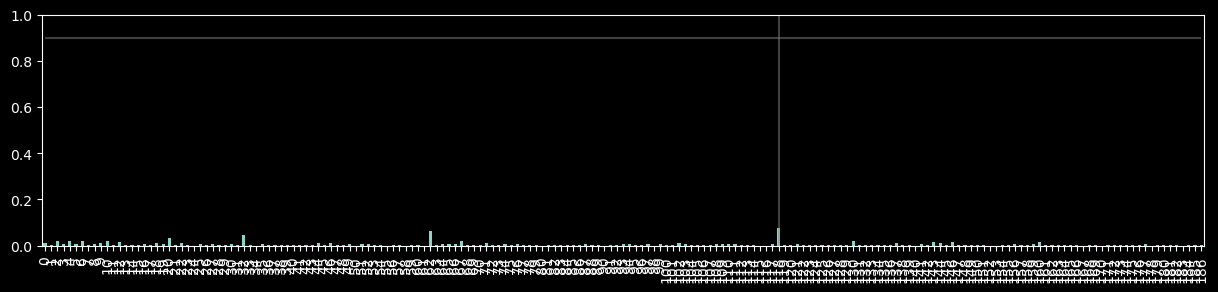

In [54]:
plot_mean_probabilities(df_probs)

In [55]:
n_position_bins = 50
bins = [0 + n * 10237/n_position_bins for n in range(n_position_bins+1)]

df_probs['pos_bin'] = pd.cut(df_probs['pos_true'], bins, retbins=False)
df_probs.pos_bin.cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins
coi.append('pos_bin')
df_probs.loc[:,coi]

,refseqid,read_kmer_id,read_50mer_nb,lbl_pred,pos_true,accuracy,pos_bin
0,11089:ncbi:1,11089:ncbi:1-17000,0,10,7804,False,39
1,11089:ncbi:1,11089:ncbi:1-17000,1,10,7804,False,39
2,11089:ncbi:1,11089:ncbi:1-17000,2,10,7804,False,39
3,11089:ncbi:1,11089:ncbi:1-17000,3,10,7804,False,39
4,11089:ncbi:1,11089:ncbi:1-17000,4,10,7804,False,39
...,...,...,...,...,...,...,...
25245,11089:ncbi:1,11089:ncbi:1-16751,96,60,4125,False,21
25246,11089:ncbi:1,11089:ncbi:1-16751,97,60,4125,False,21
25247,11089:ncbi:1,11089:ncbi:1-16751,98,60,4125,False,21
25248,11089:ncbi:1,11089:ncbi:1-16751,99,60,4125,False,21


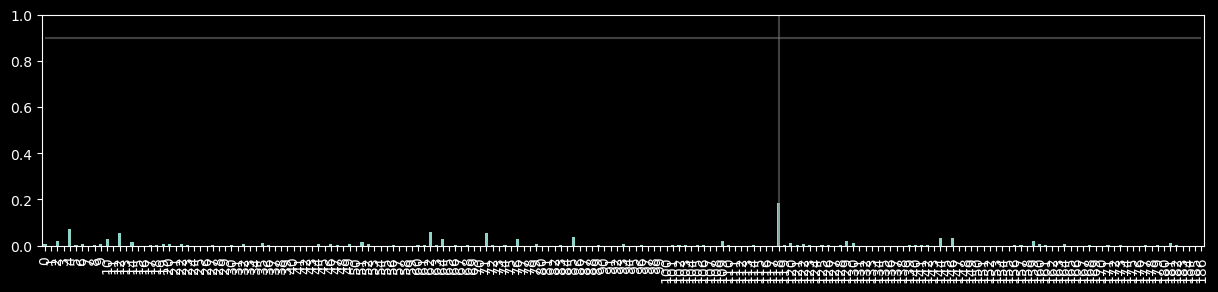

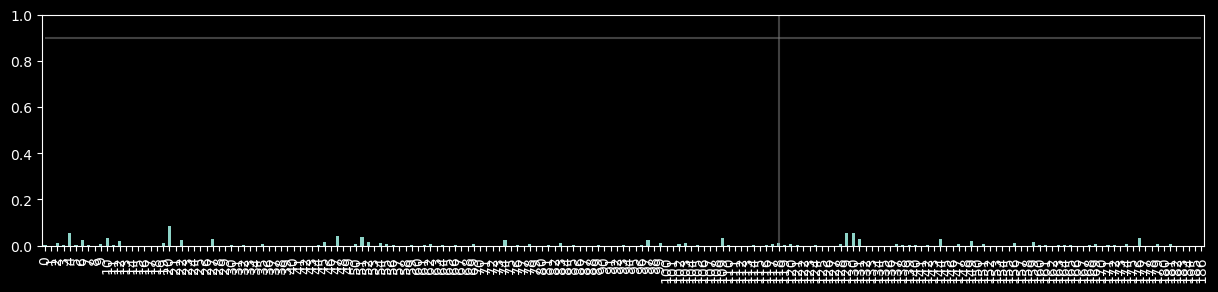

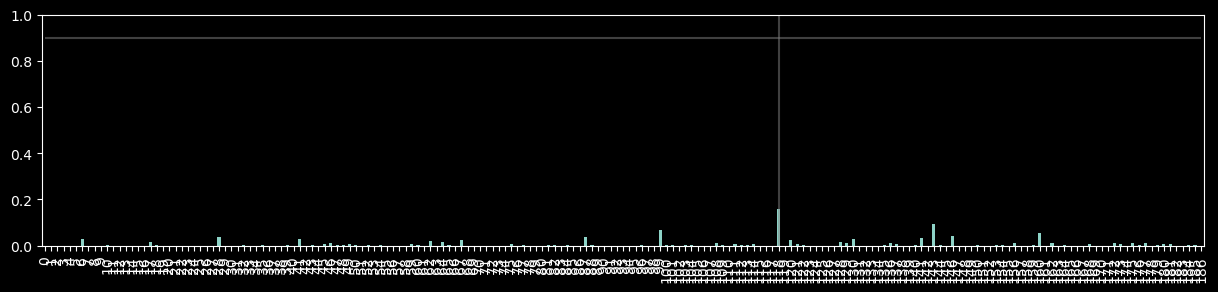

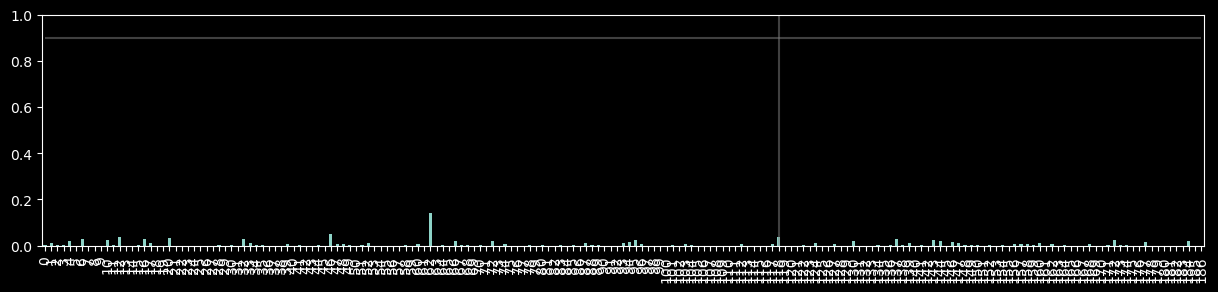

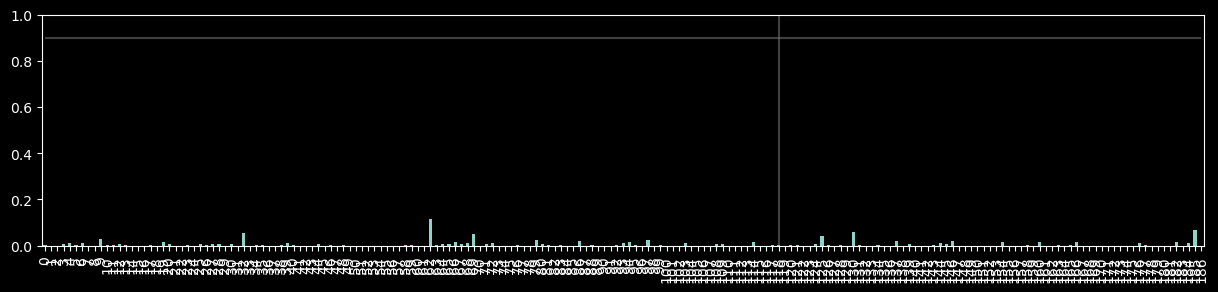

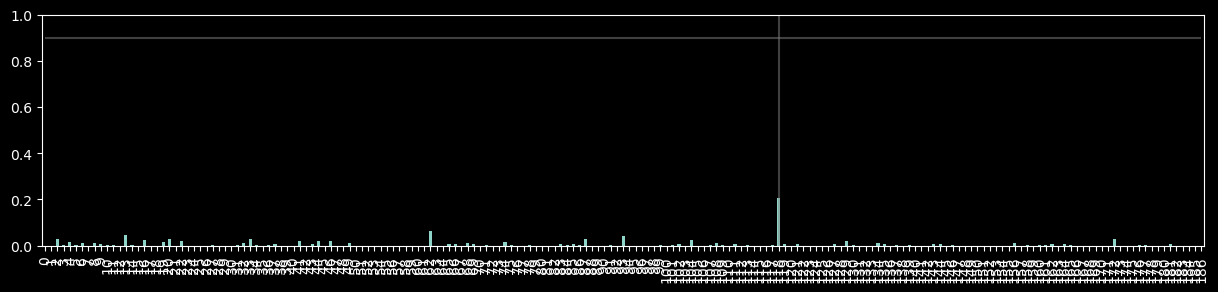

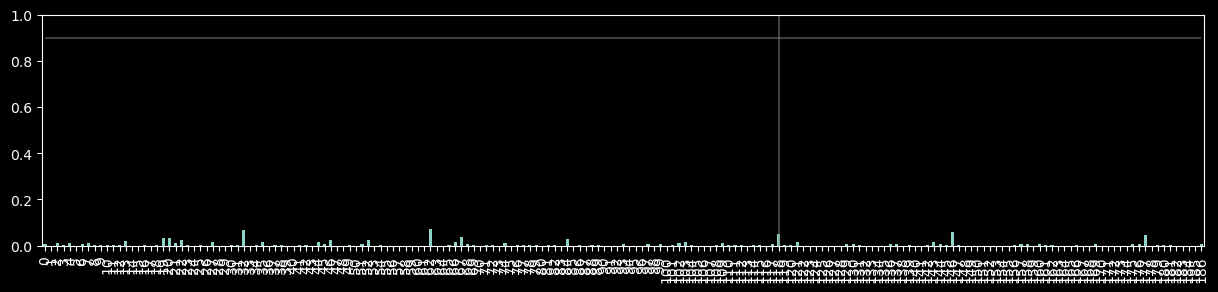

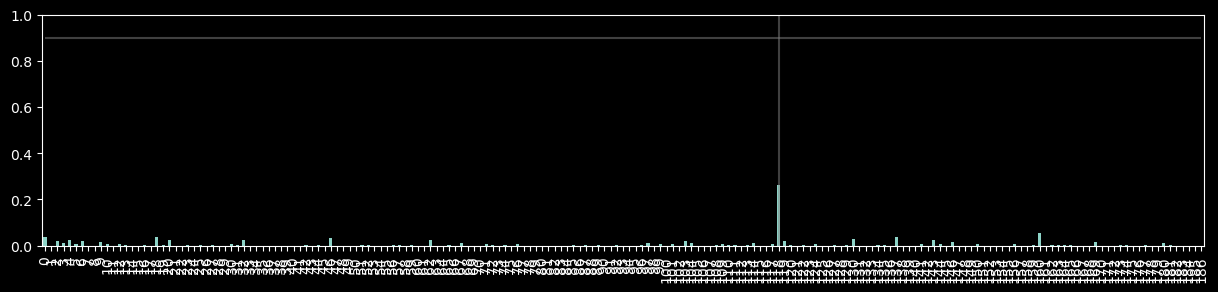

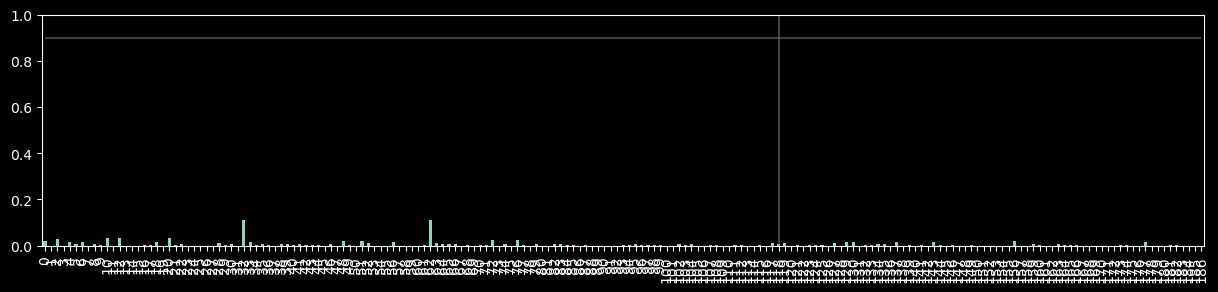

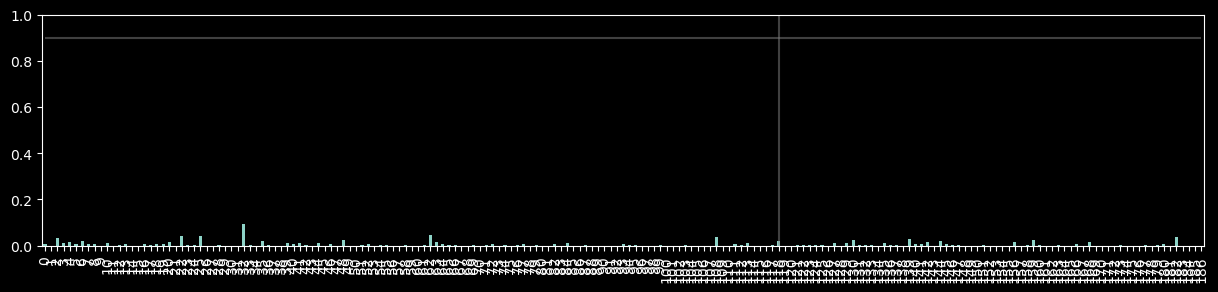

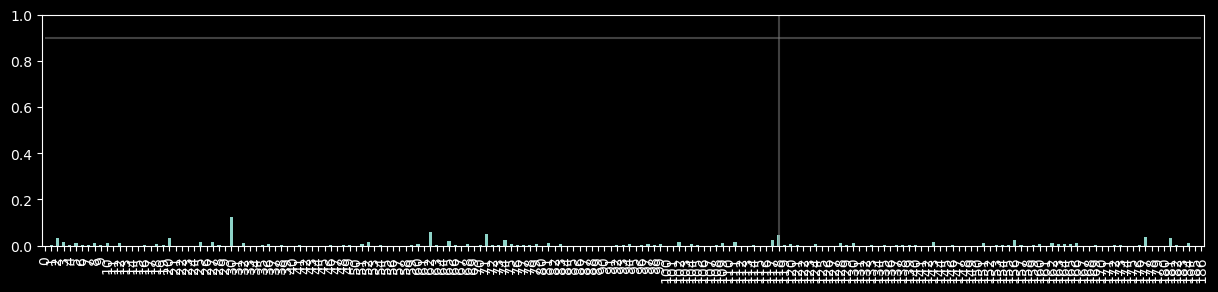

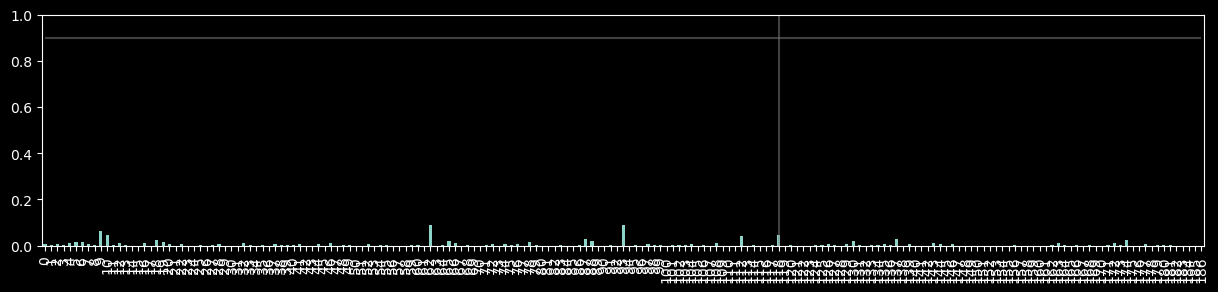

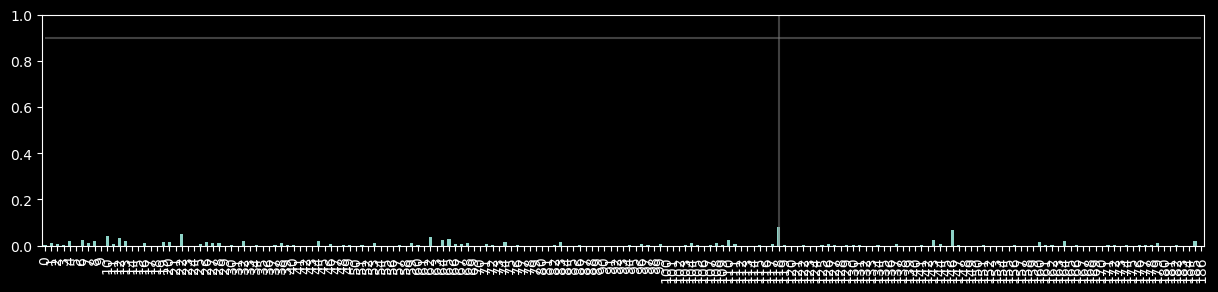

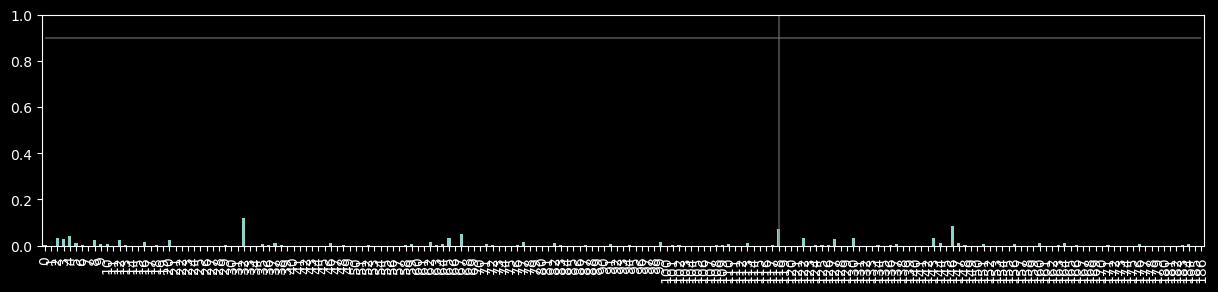

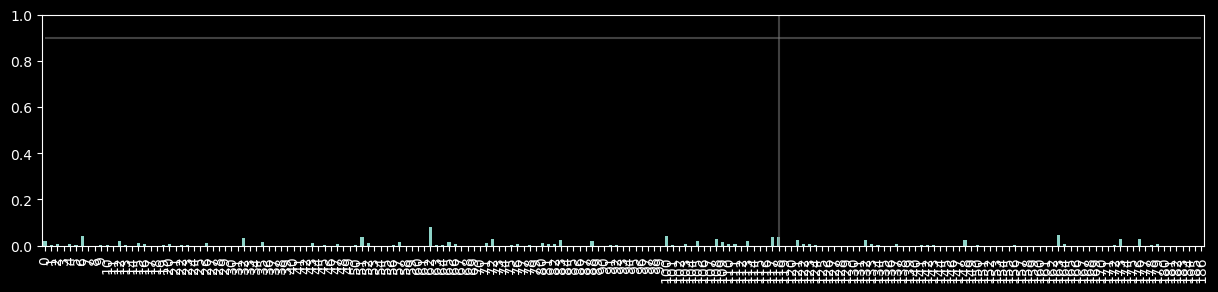

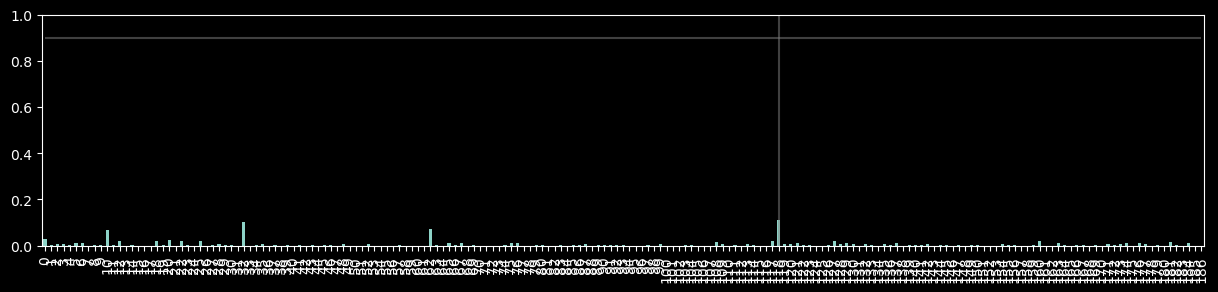

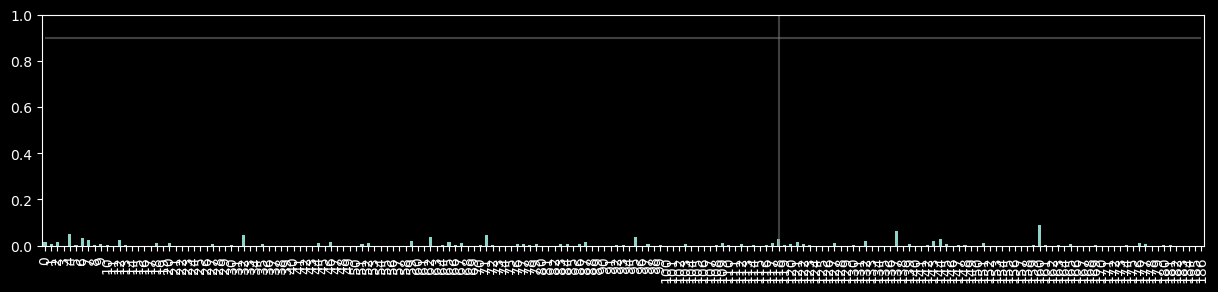

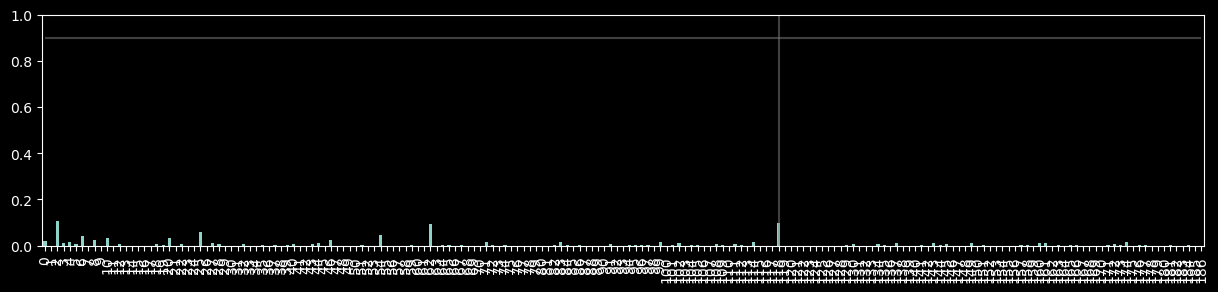

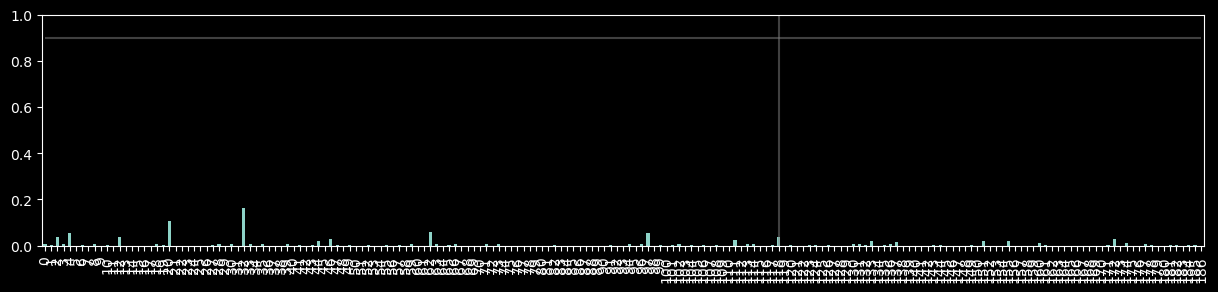

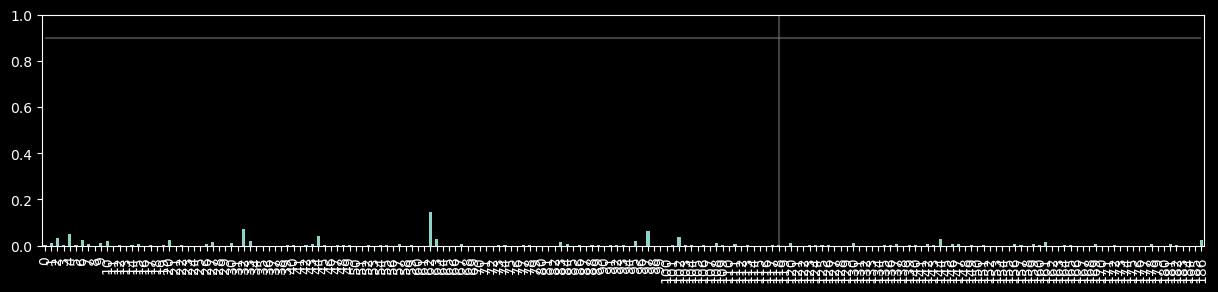

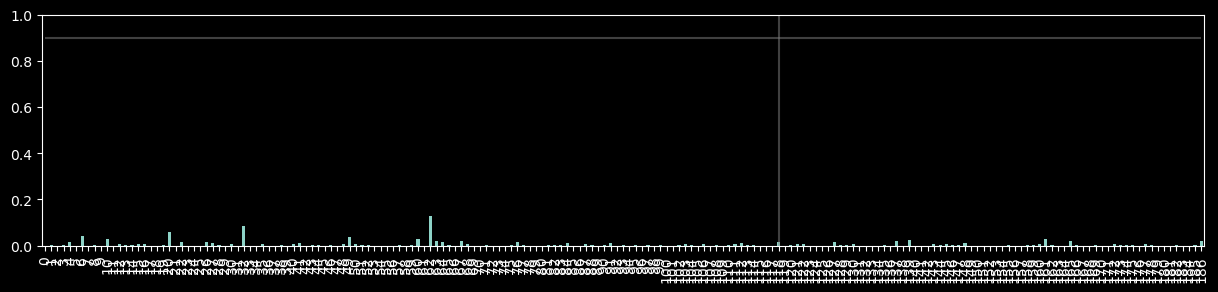

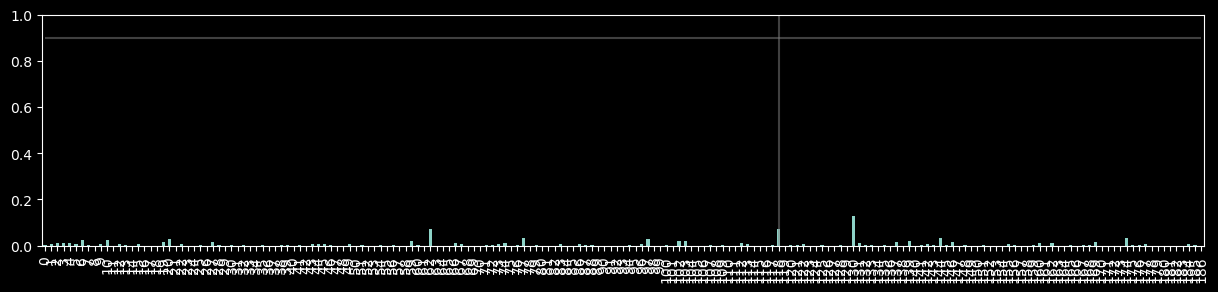

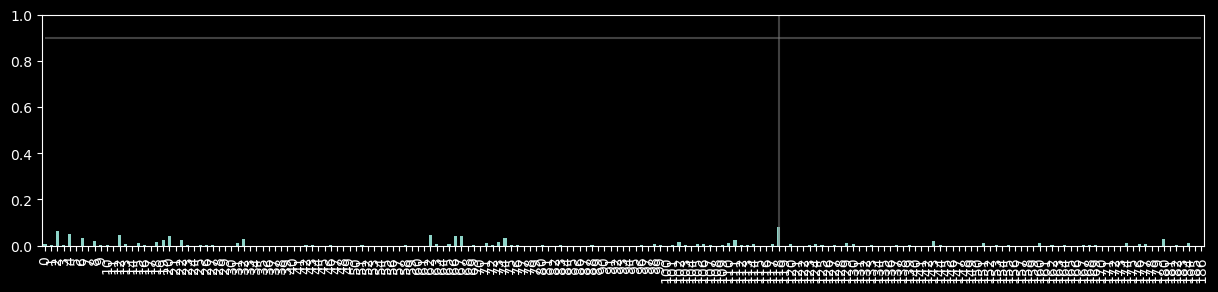

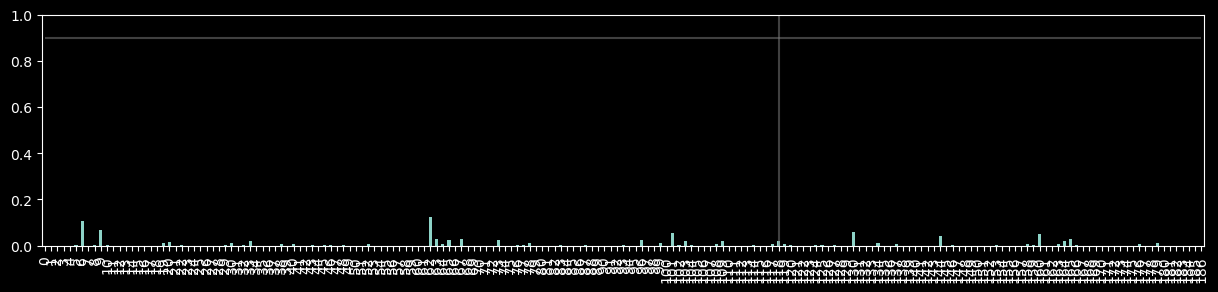

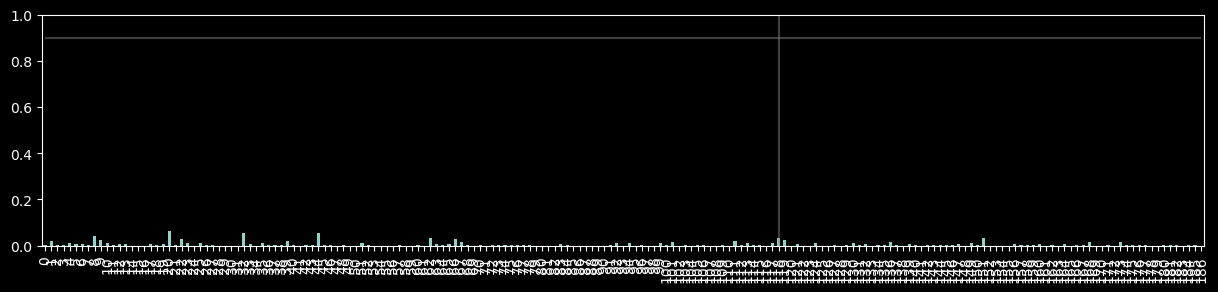

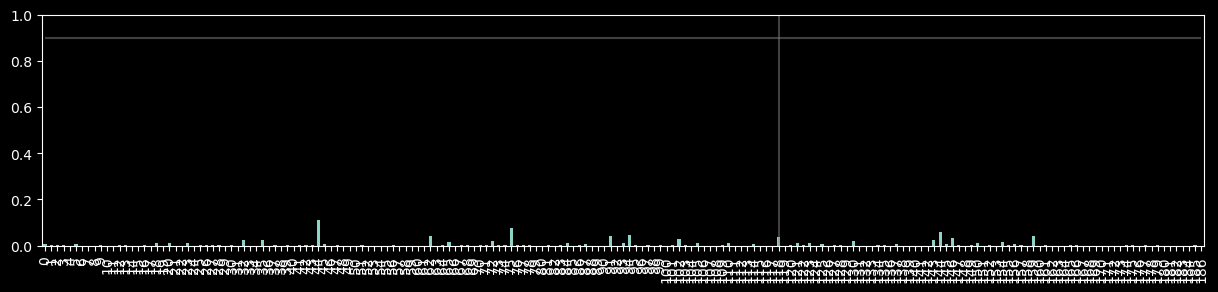

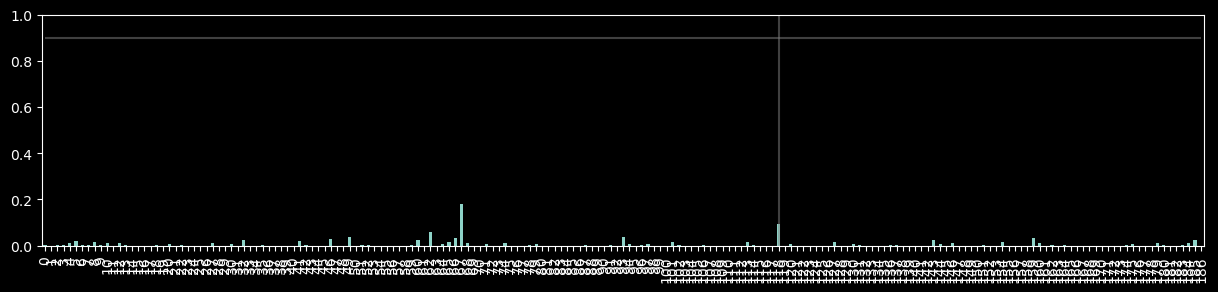

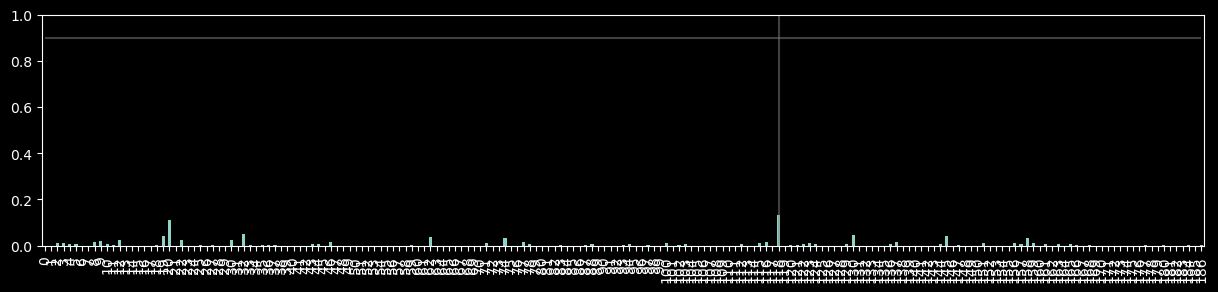

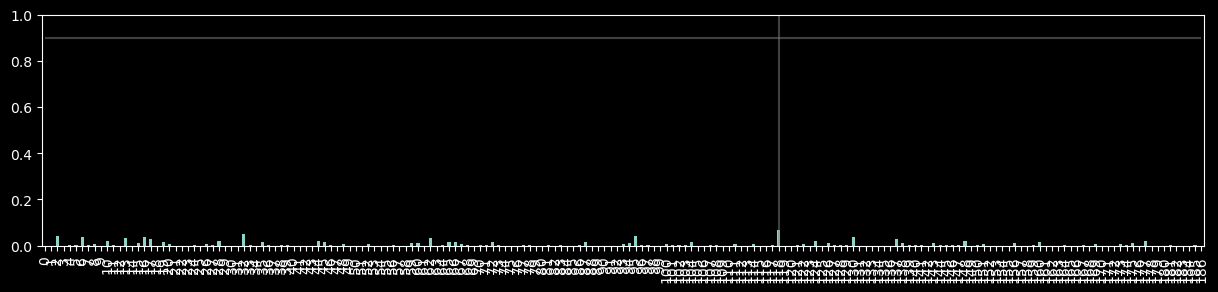

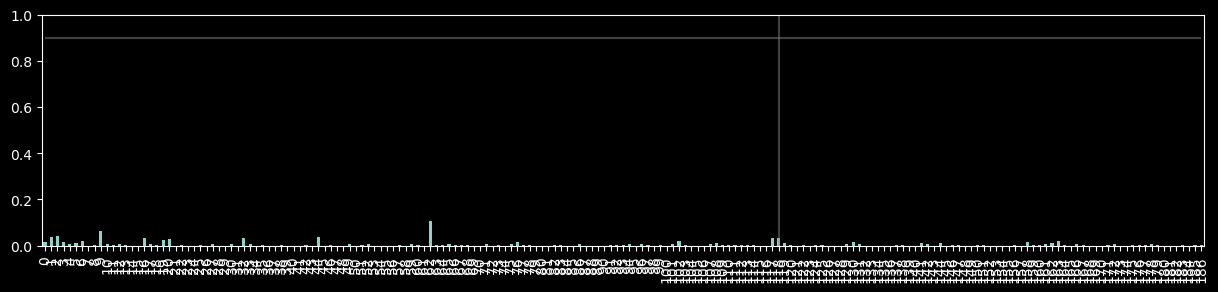

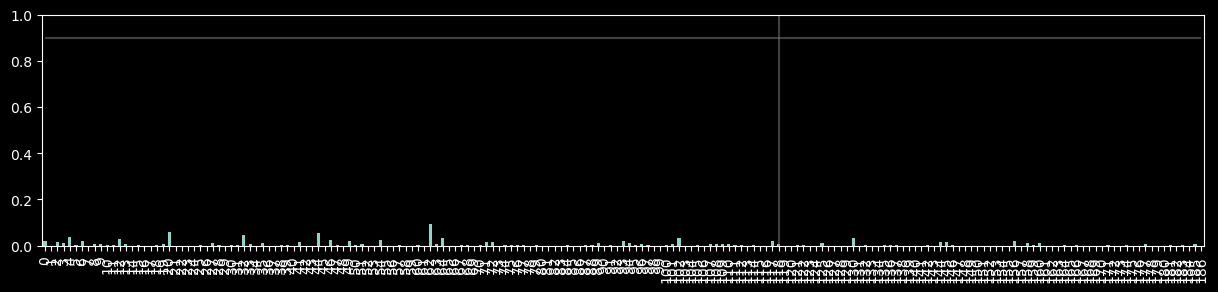

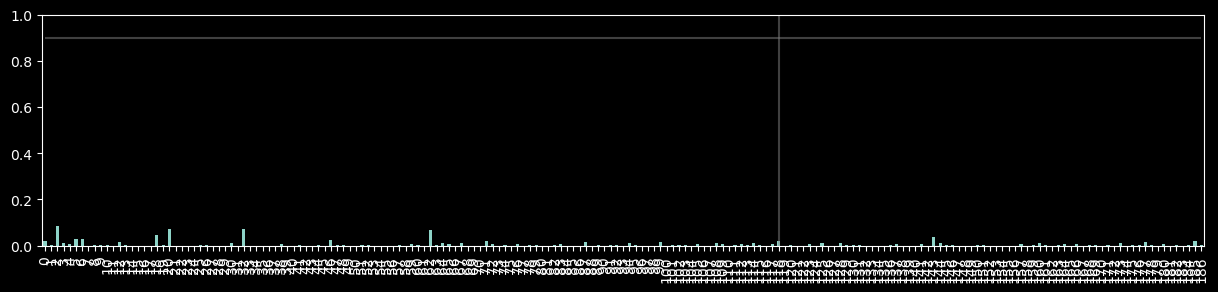

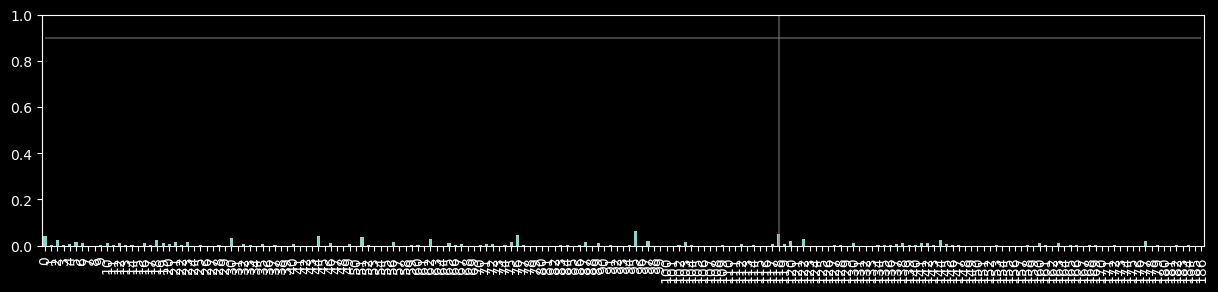

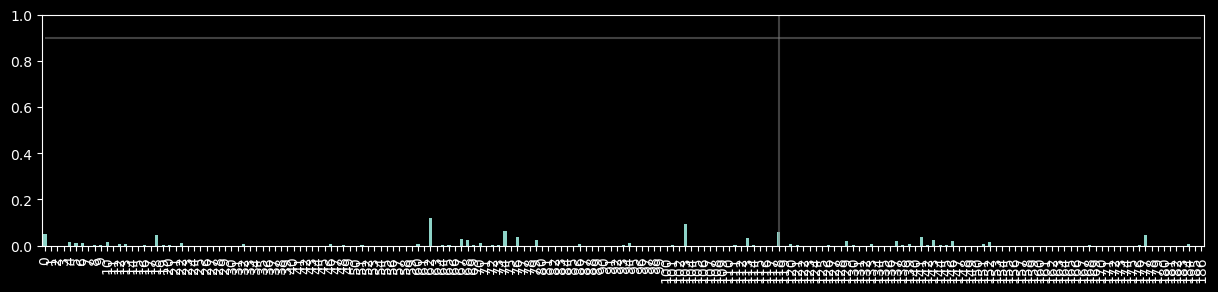

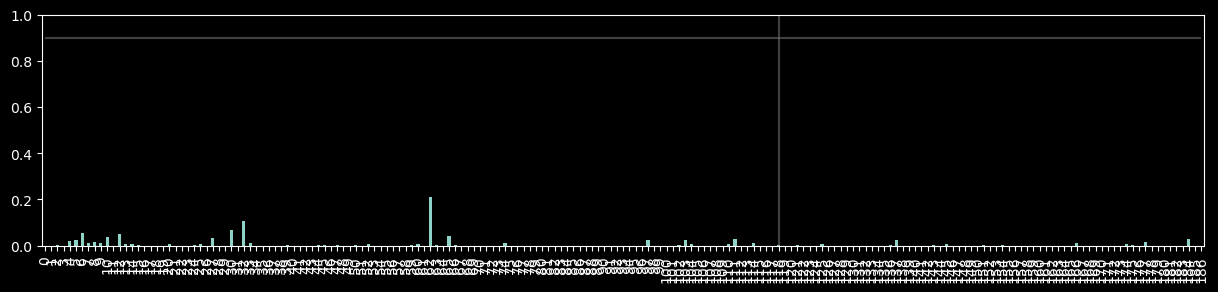

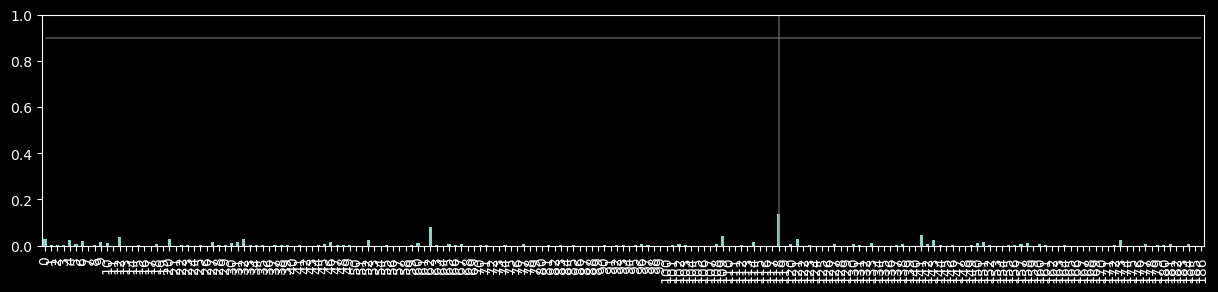

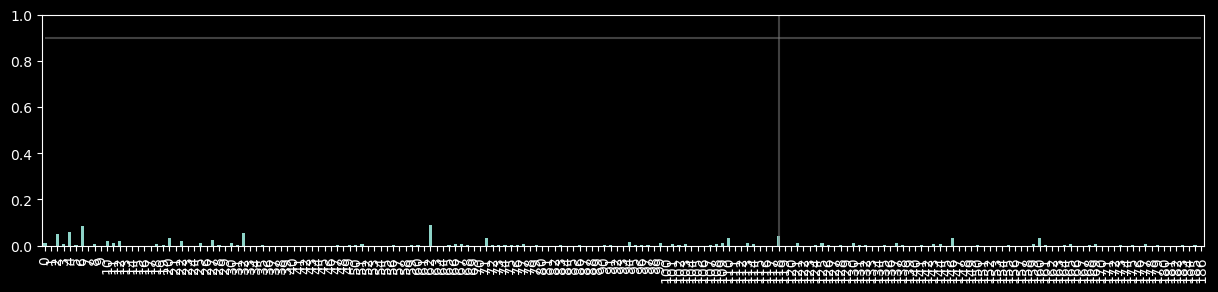

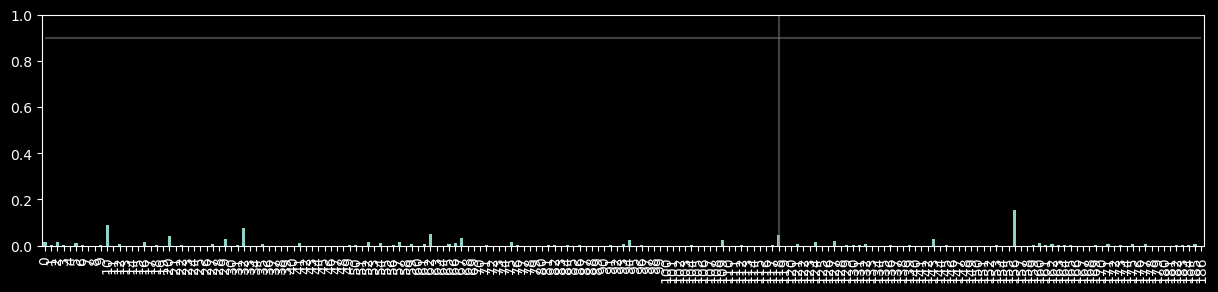

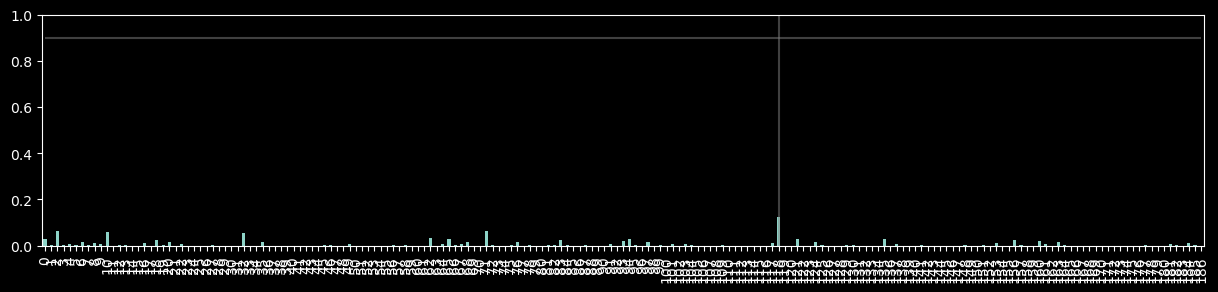

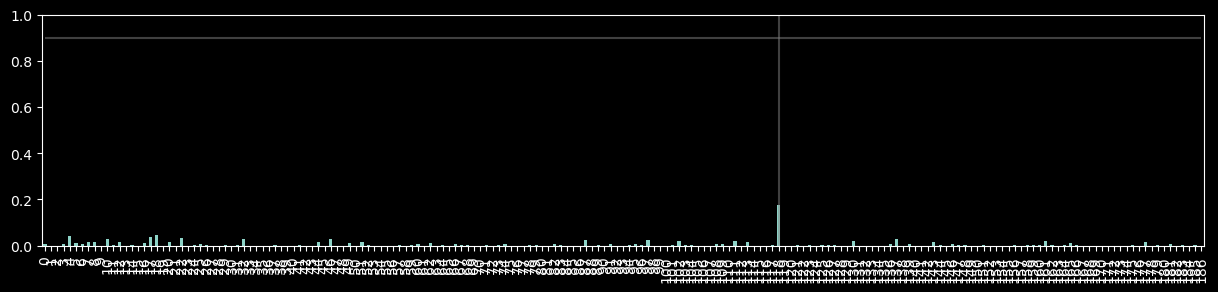

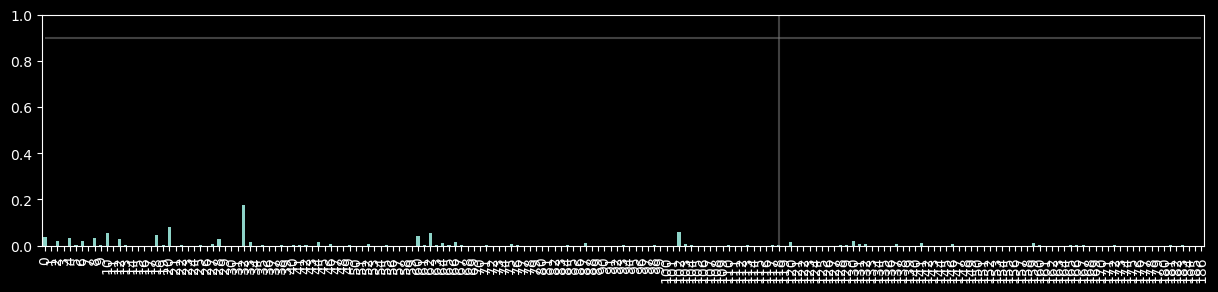

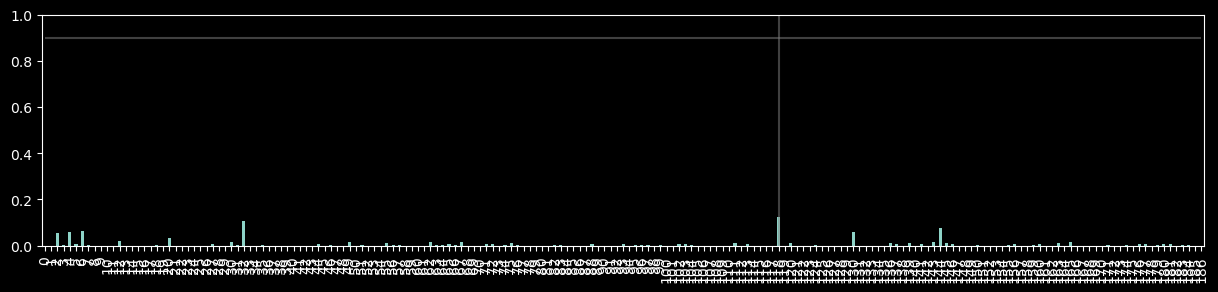

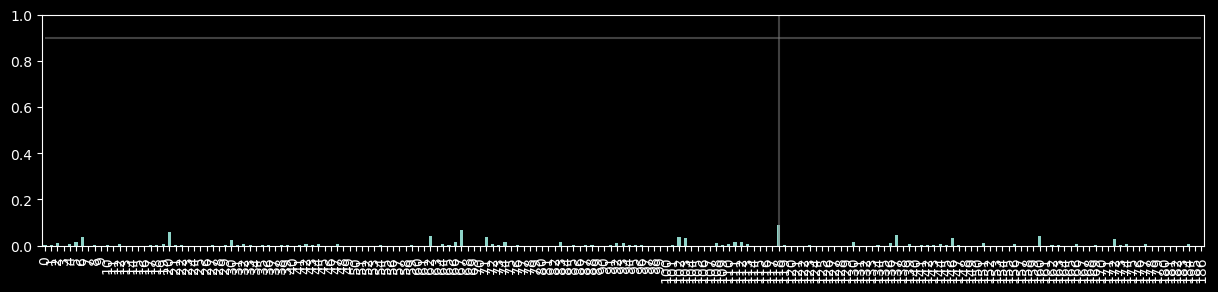

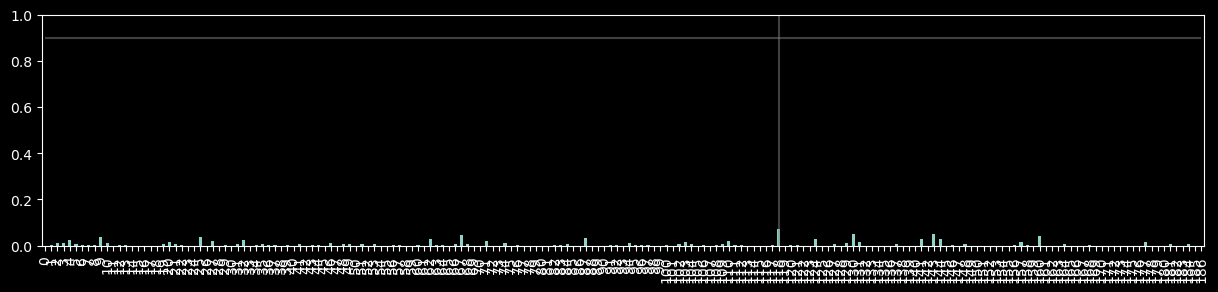

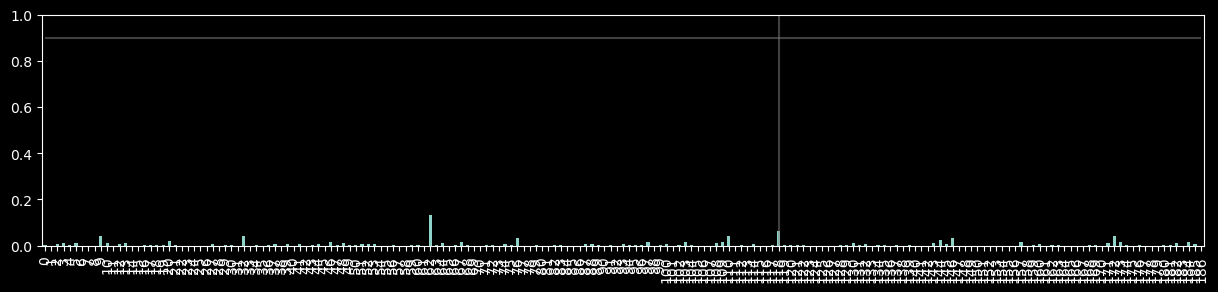

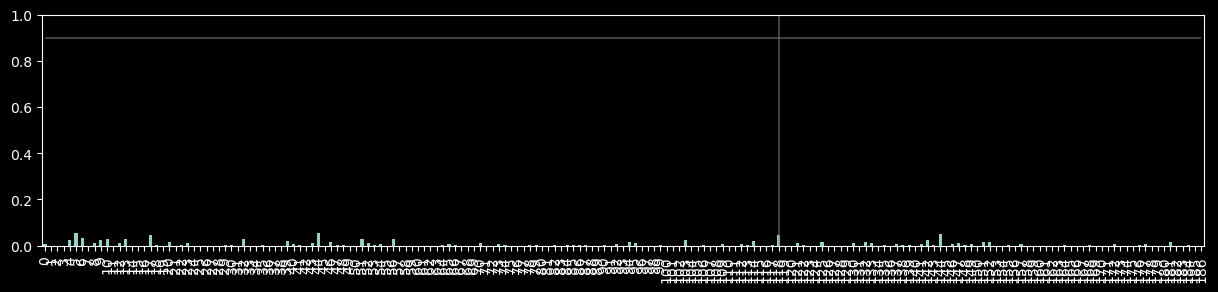

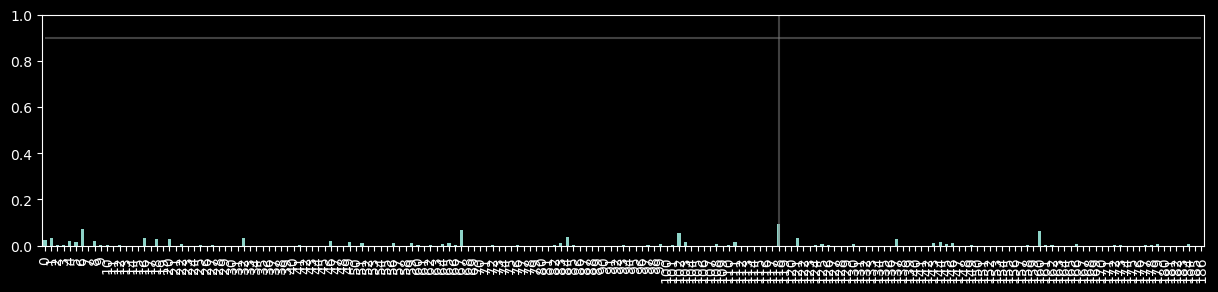

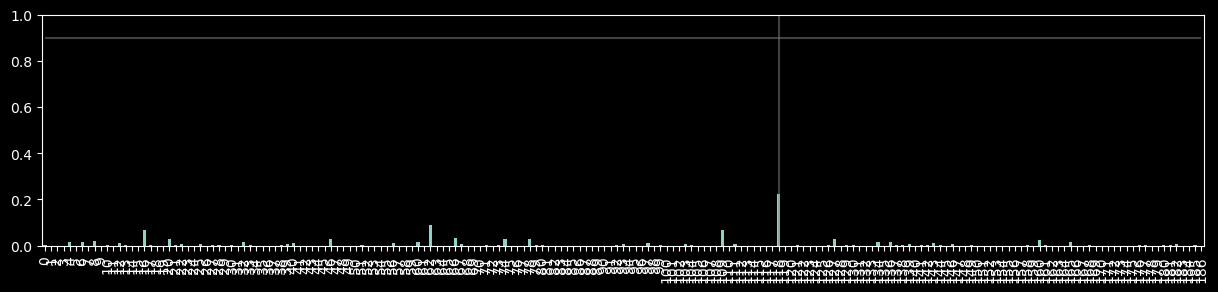

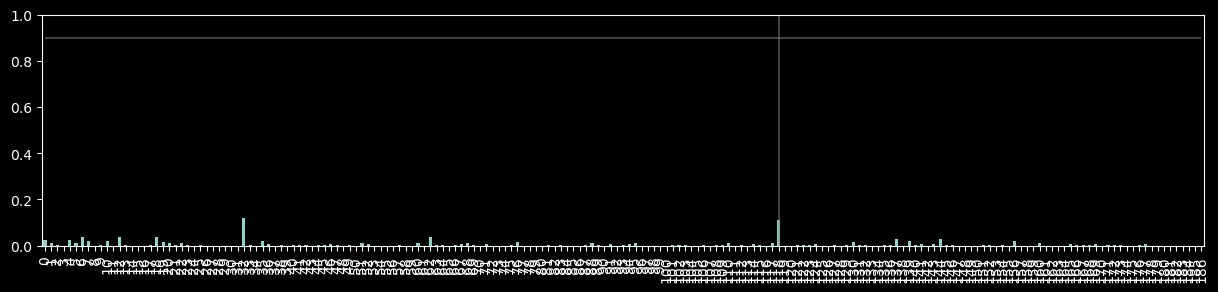

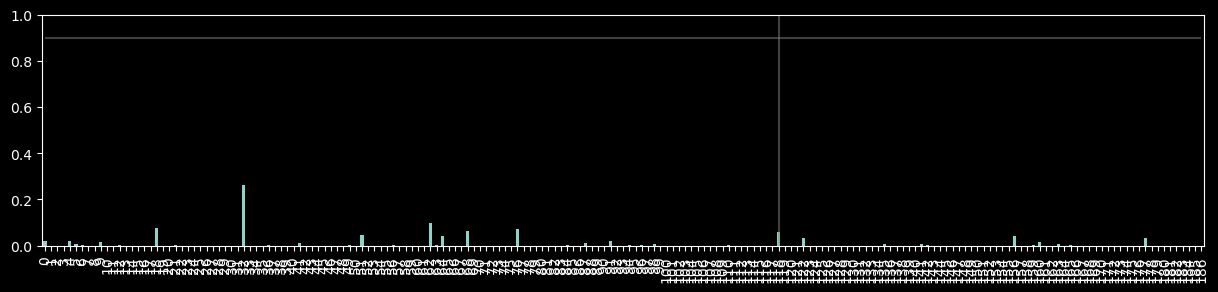

In [60]:
for b in sorted(df_probs.pos_bin.unique()):
    plot_mean_probabilities(df_probs.loc[df_probs.pos_bin == b,:])

In [ ]:
def plot_label_probs(probs, top_preds, true_labels=[118]):
    nb_seq, _ , nb_lbls = probs.shape
    assert nb_lbls == 187
    fig = plt.figure(figsize=(16, 2 * nb_seq - 1));
    # fig.suptitle('Suptitle')
    axs = []
    for i in range(nb_seq):
        if top_preds[i, 0] in true_labels: cmap = 'YlGn_r'
        else: cmap = 'YlOrRd_r'
        axs.append(plt.subplot2grid((nb_seq,1), (i,0), rowspan=1, colspan=1))
        # axs[i].axis('off')
        axs[i].imshow(probs[i,:,:], cmap=cmap, aspect='auto')
        axs[i].set_title(f"Seq {i+1} - Pred: {top_preds[i,0]} - Top Predictions; {top_preds[i]}")

    fig.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5)
    plt.show()

using `asyncio`

```python
# Python
import sqlite3
import asyncio
import aiosqlite

# Create an index on refseqid
conn = sqlite3.connect('your_database.db')
c = conn.cursor()
c.execute('CREATE INDEX IF NOT EXISTS idx_refseqid ON preds_probs(refseqid);')
conn.commit()

# Use asyncio for asynchronous database queries
async def get_data(refseqid, limit, offset):
    async with aiosqlite.connect('your_database.db') as db:
        async with db.cursor() as cursor:
            await cursor.execute(f"""
                SELECT refseqid, pos_true, read_kmer_id, read_50mer_nb, prob_001, prob_002
                FROM preds_probs 
                WHERE refseqid = '{refseqid}'
                LIMIT {limit} OFFSET {offset};
            """)
            rows = await cursor.fetchall()
            return rows

# Fetch and process data in batches
async def process_data_in_batches(refseqid, batch_size):
    offset = 0
    while True:
        batch = await get_data(refseqid, batch_size, offset)
        if not batch:
            break
        # Process batch here...
        offset += batch_size

# Run the async function
asyncio.run(process_data_in_batches('11089:ncbi:1', 500))
```

In [ ]:
%%time
# Retrieve 4 columns from rows of table label_probabilities using LIKE for 10 read_kmer_id
# Takes more than 10 min and still running
# with open_db(p2db=p2db, k=150) as conn:
#     # id, read_kmer_id, read_50mer_nb, prob_001
#     query = f"""
#     SELECT id, read_kmer_id, read_50mer_nb, prob_001
#     FROM label_probabilities 
#     WHERE read_kmer_id LIKE '11089:ncbi:1-1000%'
#     LIMIT 2500 ;
#     """
#     # print(query)
#     df_probs = pd.read_sql_query(query, conn)

# print(df_probs.shape)
# display(df_probs.tail())

In [ ]:
# with open_db(p2db=p2db, k=150) as conn:
#     # id, read_kmer_id, read_50mer_nb, prob_001
#     cursor = conn.cursor()
#     query = f"""
#     EXPLAIN QUERY PLAN
#     SELECT id, read_kmer_id, read_50mer_nb, prob_001
#     FROM label_probabilities 
#     WHERE read_kmer_id LIKE '11089:ncbi:1-1000%'
#     LIMIT 2500 ;
#     """
#     cursor.execute(query)
#     plan = cursor.fetchall()

#     for row in plan:
#         print(row)
#     print('---------------')
#     query = f"""
#     EXPLAIN QUERY PLAN
#     SELECT id, read_kmer_id, read_50mer_nb, prob_001
#     FROM label_probabilities 
#     WHERE read_kmer_id IN (
#         SELECT read_kmer_id
#         FROM label_probabilities
#         WHERE read_kmer_id LIKE '11089:ncbi:1-1000%'
#     ) 
#     LIMIT 500 ;
#     """
#     cursor.execute(query)
#     plan = cursor.fetchall()

#     for row in plan:
#         print(row)
#     print('---------------')
#     query = f"""
#     EXPLAIN QUERY PLAN
#     WITH filtered_ids AS (
#         SELECT read_kmer_id 
#         FROM label_probabilities 
#         WHERE read_kmer_id LIKE '11089:ncbi:1-1000%'
#     )
#     SELECT id, read_kmer_id, read_50mer_nb, prob_001
#     FROM label_probabilities 
#     WHERE read_kmer_id IN (SELECT read_kmer_id FROM filtered_ids)
#     LIMIT 2500;
#     """
#     cursor.execute(query)
#     plan = cursor.fetchall()

#     for row in plan:
#         print(row)

In [ ]:
# %%time
# with open_db(p2db=p2db, k=150) as conn:
#     # id, read_kmer_id, read_50mer_nb, prob_001
#     query = f"""
#     SELECT id, read_kmer_id, read_50mer_nb, prob_001
#     FROM label_probabilities 
#     WHERE read_kmer_id IN (
#         SELECT read_kmer_id
#         FROM label_probabilities
#         WHERE read_kmer_id LIKE '11089:ncbi:1-1000%'
#     ) 
#     LIMIT 500 ;
#     """

#     df_probs = pd.read_sql_query(query, conn)

# print(df_probs.shape)
# display(df_probs.tail())

In [ ]:
# %%time
# with open_db(p2db=p2db, k=150) as conn:
#     # id, read_kmer_id, read_50mer_nb, prob_001
#     query = f"""
#     SELECT id, read_kmer_id, read_50mer_nb, prob_001
#     FROM label_probabilities 
#     WHERE read_kmer_id IN (
#         SELECT read_kmer_id
#         FROM label_probabilities
#         WHERE read_kmer_id LIKE '11089:ncbi:1-1000%'
#     ) 
#     LIMIT 500 ;
#     """

#     df_probs = pd.read_sql_query(query, conn)

# print(df_probs.shape)
# display(df_probs.tail())

In [ ]:
def plot_label_probs(probs, top_preds, true_labels=[118]):
    nb_seq, _ , nb_lbls = probs.shape
    assert nb_lbls == 187
    fig = plt.figure(figsize=(16, 2 * nb_seq - 1));
    # fig.suptitle('Suptitle')
    axs = []
    for i in range(nb_seq):
        if top_preds[i, 0] in true_labels: cmap = 'YlGn_r'
        else: cmap = 'YlOrRd_r'
        axs.append(plt.subplot2grid((nb_seq,1), (i,0), rowspan=1, colspan=1))
        # axs[i].axis('off')
        axs[i].imshow(probs[i,:,:], cmap=cmap, aspect='auto')
        axs[i].set_title(f"Seq {i+1} - Pred: {top_preds[i,0]} - Top Predictions; {top_preds[i]}")

    fig.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5)
    plt.show()

# End of Section